# LR multi-tissue cross-comparison

##### Ver:: A1_V5
##### Author(s) : Issac Goh
##### Date : 220823;YYMMDD
### Author notes
    - Current defaults scrpae data from web, so leave as default and run
    - slices model and anndata to same feature shape, scales anndata object
    - added some simple benchmarking
    - creates dynamic cutoffs for probability score (x*sd of mean) in place of more memory intensive confidence scoring
    - Does not have majority voting set on as default, but module does exist
    
### Features to add
    - Add ability to consume anndata zar format for sequential learning

In [1]:
import sys
import subprocess

# import pkg_resources
# required = {'harmonypy','sklearn','scanpy','pandas', 'numpy', 'scipy', 'matplotlib', 'seaborn' ,'scipy'}
# installed = {pkg.key for pkg in pkg_resources.working_set}
# missing = required - installed
# if missing:
#    print("Installing missing packages:" )
#    print(missing)
#    python = sys.executable
#    subprocess.check_call([python, '-m', 'pip', 'install', *missing], stdout=subprocess.DEVNULL)

from collections import Counter
from collections import defaultdict
import scanpy as sc
import pandas as pd
import pickle as pkl
import numpy as np
import scipy
import matplotlib.pyplot as plt
import re
import glob
import os
import sys
#from geosketch import gs
from numpy import cov
import scipy.cluster.hierarchy as spc
import seaborn as sns; sns.set(color_codes=True)
from sklearn.linear_model import LogisticRegression
import sklearn
from pathlib import Path
import requests
import psutil
import random
import threading
import tracemalloc
import itertools
import math
import warnings

In [5]:
# variables module

models = {
'pan_fetal':'/nfs/team205/ig7/resources/scripts_dont_modify/logit_regression_models/adifa_lr/celltypist_model.Pan_Fetal_Human.pkl',
'pan_fetal_wget':'https://celltypist.cog.sanger.ac.uk/models/Pan_Fetal_Suo/v2/Pan_Fetal_Human.pkl',
'adata_scvi':'/nfs/team205/ig7/mount/gdrive/g_cloud/projects/amniontic_fluid/scvi_low_dim_model.sav',
'adata_ldvae':'/nfs/team205/ig7/mount/gdrive/g_cloud/projects/amniontic_fluid/ldvae_low_dim_model.sav',
'adata_harmony':'/nfs/team205/ig7/work_backups/backup_210306/projects/amiotic_fluid/train_low_dim_model/organ_low_dim_model.sav',
'test_low_dim_ipsc_ys':'/nfs/team205/ig7/work_backups/backup_210306/projects/YS/YS_030522_notebooks/Integrating_HM_data_030522/YS_logit/lr_model.sav',
'YS_X':'/nfs/team205/ig7/work_backups/backup_210306/projects/YS/resources/YS_X_model_080922.sav'
}
adatas_dict = {
'amnion':'/nfs/team205/ig7/work_backups/backup_210306/projects/amiotic_fluid/data/from_max/v1_a1_amnion.h5ad',
'adata_scvi':'/nfs/team205/ig7/mount/gdrive/g_cloud/projects/amniontic_fluid/scvi_model_landscape_low_dim.h5ad',
'adata_ldvae':'/nfs/team205/ig7/mount/gdrive/g_cloud/projects/amniontic_fluid/ldvae_model_landscape_low_dim.h5ad',
'adata_harmony':'/nfs/team205/ig7/mount/gdrive/g_cloud/projects/amniontic_fluid/data/model_landscape_low_dim.h5ad',
'fliv_wget_test':'https://app.cellatlas.io/fetal-liver/dataset/1/download',
'test_low_dim_ys':'/nfs/team205/ig7/work_backups/backup_210306/projects/YS/YS_030522_notebooks/Integrating_HM_data_030522/YS_logit/YS_vt_HM_YS_LR_normalised_umap.h5ad',
'matched_EL':'//lustre/scratch117/cellgen/team298/SharedFolders/YS_proj/Datasets/A4_V8_Eliver_raw_updated_metadata_20220523.h5ad',
'YS_citeseq':'/lustre/scratch117/cellgen/team298/SharedFolders/YS_proj/Datasets/ys_citeseq_rna_raw_20220701.h5ad',
'gonads':'/nfs/team205/ig7/work_backups/backup_210306/projects/YS/YS_data/Gonads/A1_V1_gonads_LR_panf_ys.h5ad',
'YS_X':'/nfs/team205/ig7/work_backups/backup_210306/projects/YS/YS_data/Submission_2_data/A2_V9_scvi_YS_integrated/A2_V9_scvi_V8_model_selected_raw_qc_scr_umap.h5ad',
'pan_organ':'/nfs/team205/ig7/work_backups/backup_210306/projects/YS/YS_data/YS_panf_gonads_brain_eliv_combined_060922/A1_V6_raw_scvi_YS_updated_panf_gonads_brain_build_donor_organ_corrected_120922.h5ad',
}

# Variable assignment
adata_key = 'pan_organ'#'fliv_wget_test' # key for dictionary entry containing local or web path to adata/s can be either url or local 
data_merge = False # read and merge multiple adata (useful, but keep false for now)
model_key = 'YS_X'#'test_low_dim_ipsc_ys'# key for model of choice can be either url or local 
train_x_partition = 'X' # what partition was the data trained on? To keep simple, for now only accepts 'X'
dyn_std = 1.96 # Dynamic cutoffs using std of the mean for each celltype probability, gives a column notifying user of uncertain labels 1 == 68Ci, 1.96 = 95CI
freq_redist = 'celltype_annotation_v2'#'cell.labels'#'False#'cell.labels'#False # False or key of column in anndata object which contains labels/clusters // not currently implemented

# Partial scaling ver
- scale across 10 mini bulks/every 100,000 cells
- sequential learning for scaling
- sequential application of scaling

In [10]:
def load_models(model_dict,model_run):
    if (Path(model_dict[model_run])).is_file():
        # Load data (deserialize)
        model = pkl.load(open(model_dict[model_run], "rb"))
        return model
    elif 'https' in model_dict[model_run]:
        print('Loading model from web source')
        r_get = requests.get(model_dict[model_run])
        fpath = './model_temp.sav'
        open(fpath , 'wb').write(r_get.content)
        model = pkl.load(open(fpath, "rb"))
        return model

def load_adatas(adatas_dict,data_merge, data_key_use):
    if data_merge == True:
        # Read
        gene_intersect = {} # unused here
        adatas = {}
        for dataset in adatas_dict.keys():
            if 'https' in adatas_dict[dataset]:
                print('Loading anndata from web source')
                adatas[dataset] = sc.read('./temp_adata.h5ad',backup_url=adatas_dict[dataset])
            adatas[dataset] = sc.read(data[dataset])
            adatas[dataset].var_names_make_unique()
            adatas[dataset].obs['dataset_merge'] = dataset
            adatas[dataset].obs['dataset_merge'] = dataset
            gene_intersect[dataset] = list(adatas[dataset].var.index)
        adata = list(adatas.values())[0].concatenate(list(adatas.values())[1:],join='inner')
        return adatas, adata
    elif data_merge == False:
        if 'https' in adatas_dict[data_key_use]:
            print('Loading anndata from web source')
            adata = sc.read('./temp_adata.h5ad',backup_url=adatas_dict[data_key_use])
        else: 
            adata = sc.read(adatas_dict[data_key_use])
        del adata.uns
        del adata.obsp
        return adata

# resource usage logger
class DisplayCPU(threading.Thread):
    def run(self):
        tracemalloc.start()
        starting, starting_peak = tracemalloc.get_traced_memory()
        self.running = True
        self.starting = starting
        currentProcess = psutil.Process()
        cpu_pct = []
        while self.running:
            peak_cpu = 0
#           time.sleep(3)
#             print('CPU % usage = '+''+ str(currentProcess.cpu_percent(interval=1)))
#             cpu_pct.append(str(currentProcess.cpu_percent(interval=1)))
            cpu = currentProcess.cpu_percent()
        # track the peak utilization of the process
            if cpu > peak_cpu:
                peak_cpu = cpu
                peak_cpu_per_core = peak_cpu/psutil.cpu_count()
        self.peak_cpu = peak_cpu
        self.peak_cpu_per_core = peak_cpu_per_core
        
    def stop(self):
#        cpu_pct = DisplayCPU.run(self)
        self.running = False
        current, peak = tracemalloc.get_traced_memory()
        tracemalloc.stop()
        return current, peak
    
# projection module
def reference_projection(adata, model, dyn_std):
    
    class adata_temp:
        pass
    from sklearn.preprocessing import StandardScaler
    print('Determining model flavour')
    if hasattr(model, 'Model'):
        print('Consuming celltypist model')
        model_lr =  model['Model']
    else:# hasattr(model, 'coef_'):
        print('Consuming non-celltypist model')
        model_lr =  model
    print(model_lr)
    
#     model_lr =  model['Model']
        
    if train_x_partition == 'X':
        print('Matching reference genes in the model')
        k_x = np.isin(list(adata.var.index), list(model_lr.features))
        if k_x.sum() == 0:
            raise ValueError(f"🛑 No features overlap with the model. Please provide gene symbols")
        print(f"🧬 {k_x.sum()} features used for prediction")
        #slicing adata
        k_x_idx = np.where(k_x)[0]
        # adata_temp = adata[:,k_x_idx]
        adata_temp.var = adata[:,k_x_idx].var
        adata_temp.X = adata[:,k_x_idx].X
        adata_temp.obs = adata[:,k_x_idx].obs
        lr_idx = pd.DataFrame(model_lr.features, columns=['features']).reset_index().set_index('features').loc[list(adata_temp.var.index)].values
        # adata_arr = adata_temp.X[:,list(lr_idexes['index'])]

        # slice and reorder model
        ni, fs, cf = model_lr.n_features_in_, model_lr.features, model_lr.coef_
        model_lr.n_features_in_ = lr_idx.size
        model_lr.features = model_lr.features[lr_idx]
        model_lr.coef_ = np.squeeze(model_lr.coef_[:,lr_idx]) #model_lr.coef_[:, lr_idx]

        print('scaling input data, default option is to use incremental learning and fit in mini bulks!')
        # Partial scaling alg
        scaler = StandardScaler(with_mean=False)
        n = adata_temp.X.shape[0]  # number of rows
        # set dyn scale packet size
        x_len = len(adata_temp.var)
        y_len = len(adata.obs)
        if y_len < 100000:
            dyn_pack = int(x_len/10)
            pack_size = dyn_pack
        else:
            # 10 pack for every 100,000
            dyn_pack = int((y_len/100000)*10)
            pack_size = int(x_len/dyn_pack)

        batch_size =  1000#pack_size#500  # number of rows in each call to partial_fit
        index = 0  # helper-var
        while index < n:
            partial_size = min(batch_size, n - index)  # needed because last loop is possibly incomplete
            partial_x = adata_temp.X[index:index+partial_size]
            scaler.partial_fit(partial_x)
            index += partial_size
        adata_temp.X = scaler.transform(adata_temp.X)
    
    # model projections
    print('Starting reference projection!')
    if train_x_partition == 'X':
        train_x = adata_temp.X
        pred_out = pd.DataFrame(model_lr.predict(train_x),columns = ['predicted'],index = list(adata.obs.index))
        proba =  pd.DataFrame(model_lr.predict_proba(train_x),columns = model_lr.classes_,index = list(adata.obs.index))
        pred_out = pred_out.join(proba)
        
    elif train_x_partition in list(adata.obsm.keys()): 
        print('{low_dim: this partition modality is still under development!}')
        train_x = adata.obsm[train_x_partition]
        pred_out = pd.DataFrame(model_lr.predict(train_x),columns = ['predicted'],index = list(adata.obs.index))
        proba =  pd.DataFrame(model_lr.predict_proba(train_x),columns = model_lr.classes_,index = list(adata.obs.index))
        pred_out = pred_out.join(proba)
    
    else:
        print('{this partition modality is still under development!}')
    ## insert modules for low dim below

    # Simple dynamic confidence calling
    pred_out['confident_calls'] = pred_out['predicted']
    pred_out.loc[pred_out.max(axis=1)<(pred_out.mean(axis=1) + (1*pred_out.std(axis=1))),'confident_calls'] = pred_out.loc[pred_out.max(axis=1)<(pred_out.mean(axis=1) + (1*pred_out.std(axis=1))),'confident_calls'].astype(str) + '_uncertain'
    # means_ = self.model.scaler.mean_[lr_idx] if self.model.scaler.with_mean else 0
    return(pred_out,train_x,model_lr,adata_temp)

def freq_redist_68CI(adata,clusters_reassign):
    if freq_redist != False:
        print('Frequency redistribution commencing')
        cluster_prediction = "consensus_clus_prediction"
        lr_predicted_col = 'predicted'
        pred_out[clusters_reassign] = adata.obs[clusters_reassign].astype(str)
        reassign_classes = list(pred_out[clusters_reassign].unique())
        lm = 1 # lambda value
        pred_out[cluster_prediction] = pred_out[clusters_reassign]
        for z in pred_out[clusters_reassign][pred_out[clusters_reassign].isin(reassign_classes)].unique():
            df = pred_out
            df = df[(df[clusters_reassign].isin([z]))]
            df_count = pd.DataFrame(df[lr_predicted_col].value_counts())
            # Look for classificationds > 68CI
            if len(df_count) > 1:
                df_count_temp = df_count[df_count[lr_predicted_col]>int(int(df_count.mean()) + (df_count.std()*lm))]
                if len(df_count_temp >= 1):
                    df_count = df_count_temp
            #print(df_count)     
            freq_arranged = df_count.index
            cat = freq_arranged[0]
        #Make the cluster assignment first
            pred_out[cluster_prediction] = pred_out[cluster_prediction].astype(str)
            pred_out.loc[pred_out[clusters_reassign] == z, [cluster_prediction]] = cat
        # Create assignments for any classification >68CI
            for cats in freq_arranged:
                #print(cats)
                cats_assignment = cats#.replace(data1,'') + '_clus_prediction'
                pred_out.loc[(pred_out[clusters_reassign] == z) & (pred_out[lr_predicted_col] == cats),[cluster_prediction]] = cats_assignment
        min_counts = pd.DataFrame((pred_out[cluster_prediction].value_counts()))
        reassign = list(min_counts.index[min_counts[cluster_prediction]<=2])
        pred_out[cluster_prediction] = pred_out[cluster_prediction].str.replace(str(''.join(reassign)),str(''.join(pred_out.loc[pred_out[clusters_reassign].isin(list(pred_out.loc[(pred_out[cluster_prediction].isin(reassign)),clusters_reassign])),lr_predicted_col].value_counts().head(1).index.values)))
        return pred_out

### Feature importance notes
#- If we increase the x feature one unit, then the prediction will change e to the power of its weight. We can apply this rule to the all weights to find the feature importance.
#- We will calculate the Euler number to the power of its coefficient to find the importance.
#- To sum up an increase of x feature by one unit increases the odds of being versicolor class by a factor of x[importance] when all other features remain the same.

#- For low-dim, we look at the distribution of e^coef per class, we extract the 


# class coef_extract:
#     def __init__(self, model,features, pos):
# #         self.w = list(itertools.chain(*(model.coef_[pos]).tolist())) #model.coef_[pos]
#         self.w = model.coef_[class_pred_pos]
#         self.features = features 

def long_format_features(top_loadings):
    p = top_loadings.loc[:, top_loadings.columns.str.endswith("_e^coef")]
    p = pd.melt(p)
    n = top_loadings.loc[:, top_loadings.columns.str.endswith("_feature")]
    n = pd.melt(n)
    l = top_loadings.loc[:, top_loadings.columns.str.endswith("_coef")]
    l = pd.melt(l)
    n = n.replace(regex=r'_feature', value='')
    n = n.rename(columns={"variable": "class", "value": "feature"})
    p = (p.drop(["variable"],axis = 1)).rename(columns={ "value": "e^coef"})
    l = (l.drop(["variable"],axis = 1)).rename(columns={ "value": "coef"})
    concat = pd.concat([n,p,l],axis=1)
    return concat

def model_feature_sf(long_format_feature_importance, coef_use):
        long_format_feature_importance[str(coef_use) + '_pval'] = 'NaN'
        for class_lw in long_format_feature_importance['class'].unique():
            df_loadings = long_format_feature_importance[long_format_feature_importance['class'].isin([class_lw])]
            comps = coef_use #'e^coef'
            U = np.mean(df_loadings[comps])
            std = np.std(df_loadings[comps])
            med =  np.median(df_loadings[comps])
            mad = np.median(np.absolute(df_loadings[comps] - np.median(df_loadings[comps])))
            # Survival function scaled by 1.4826 of MAD (approx norm)
            pvals = scipy.stats.norm.sf(df_loadings[comps], loc=med, scale=1.4826*mad) # 95% CI of MAD <10,000 samples
            #pvals = scipy.stats.norm.sf(df_loadings[comps], loc=U, scale=1*std)
            df_loadings[str(comps) +'_pval'] = pvals
            long_format_feature_importance.loc[long_format_feature_importance.index.isin(df_loadings.index)] = df_loadings
        long_format_feature_importance['is_significant_sf'] = False
        long_format_feature_importance.loc[long_format_feature_importance[coef_use+ '_pval']<0.05,'is_significant_sf'] = True
        return long_format_feature_importance
# Apply SF to e^coeff mat data
#         pval_mat = pd.DataFrame(columns = mat.columns)
#         for class_lw in mat.index:
#             df_loadings = mat.loc[class_lw]
#             U = np.mean(df_loadings)
#             std = np.std(df_loadings)
#             med =  np.median(df_loadings)
#             mad = np.median(np.absolute(df_loadings - np.median(df_loadings)))
#             pvals = scipy.stats.norm.sf(df_loadings, loc=med, scale=1.96*U)

class estimate_important_features: # This calculates feature effect sizes of the model
    def __init__(self, model, top_n):
        print('Estimating feature importance')
        classes =  list(model.classes_)
         # get feature names
        try:
            model_features = list(itertools.chain(*list(model.features)))
        except:
            warnings.warn('no features recorded in data, naming features by position')
            print('if low-dim lr was submitted, run linear decoding function to obtain true feature set')
            model_features = list(range(0,model.coef_.shape[1]))
            model.features = model_features
        print('Calculating the Euler number to the power of coefficients')
        impt_ = pow(math.e,model.coef_)
        try:
            self.euler_pow_mat = pd.DataFrame(impt_,columns = list(itertools.chain(*list(model.features))),index = list(model.classes_))
        except:
            self.euler_pow_mat = pd.DataFrame(impt_,columns = list(model.features),index = list(model.classes_))
        self.top_n_features = pd.DataFrame(index = list(range(0,top_n)))
        # estimate per class feature importance
        
        print('Estimating feature importance for each class')
        mat = self.euler_pow_mat
        for class_pred_pos in list(range(0,len(mat.T.columns))):
            class_pred = list(mat.T.columns)[class_pred_pos]
            #     print(class_pred)
            temp_mat =  pd.DataFrame(mat.T[class_pred])
            temp_mat['coef'] = model.coef_[class_pred_pos]
            temp_mat = temp_mat.sort_values(by = [class_pred], ascending=False)
            temp_mat = temp_mat.reset_index()
            temp_mat.columns = ['feature','e^coef','coef']
            temp_mat = temp_mat[['feature','e^coef','coef']]
            temp_mat.columns =str(class_pred)+ "_" + temp_mat.columns
            self.top_n_features = pd.concat([self.top_n_features,temp_mat.head(top_n)], join="inner",ignore_index = False, axis=1)
            self.to_n_features_long = model_feature_sf(long_format_features(self.top_n_features),'e^coef')
            
    
    # plot class-wise features
def model_class_feature_plots(top_loadings, classes, comps):
    import matplotlib.pyplot as plt
    %matplotlib inline  
    for class_temp in classes:
        class_lw = class_temp
        long_format = top_loadings
        df_loadings = long_format[long_format['class'].isin([class_lw])]
        plt.hist(df_loadings[comps])
        for i in ((df_loadings[comps][df_loadings[str(comps) +'_pval']<0.05]).unique()):
            plt.axvline(x=i,color='red')
        med = np.median(df_loadings[comps])
        plt.axvline(x=med,color='blue')
        plt.xlabel('feature_importance', fontsize=12)
        plt.title(class_lw)
        #plt.axvline(x=med,color='pink')
        df_loadings[comps][df_loadings[str(comps) +'_pval']<0.05]
        print(len(df_loadings[comps][df_loadings[str(comps) +'_pval']<0.05]))
        #Plot feature ranking
        plot_loading = pd.DataFrame(pd.DataFrame(df_loadings[comps][df_loadings[str(comps) +'_pval']<0.05]).iloc[:,0].sort_values(ascending=False))
        table = plt.table(cellText=plot_loading.values,colWidths = [1]*len(plot_loading.columns),
        rowLabels= list(df_loadings['feature'][df_loadings.index.isin(plot_loading.index)].reindex(plot_loading.index)), #plot_loading.index,
        colLabels=plot_loading.columns,
        cellLoc = 'center', rowLoc = 'center',
        loc='right', bbox=[1.4, -0.05, 0.5,1])
        table.scale(1, 2)
        table.set_fontsize(16)
        
def report_f1(model,train_x, train_label):
    ## Report accuracy score
    from sklearn.model_selection import cross_val_score
    from sklearn.model_selection import RepeatedStratifiedKFold
    from sklearn import metrics
    import seaborn as sn
    import pandas as pd
    from sklearn.metrics import confusion_matrix
    import matplotlib.pyplot as plt
    
    # cv = RepeatedStratifiedKFold(n_splits=2, n_repeats=2, random_state=1)
    # # evaluate the model and collect the scores
    # n_scores = cross_val_score(lr, train_x, train_label, scoring='accuracy', cv=cv, n_jobs=-1)
    # # report the model performance
    # print('Mean Accuracy: %.3f (%.3f)' % (np.mean(n_scores), np.std(n_scores)))

    # Report Precision score
    metric = pd.DataFrame((metrics.classification_report(train_label, model.predict(train_x), digits=2,output_dict=True))).T
    cm = confusion_matrix(train_label, model.predict(train_x))
    #cm = confusion_matrix(train_label, model.predict_proba(train_x))
    df_cm = pd.DataFrame(cm, index = lr.classes_,columns = lr.classes_)
    df_cm = (df_cm / df_cm.sum(axis=0))*100
    plt.figure(figsize = (20,15))
    sn.set(font_scale=1) # for label size
    pal = sns.diverging_palette(240, 10, n=10)
    #plt.suptitle(('Mean Accuracy 5 fold: %.3f std: %.3f' % (np.mean(n_scores),  np.std(n_scores))), y=1.05, fontsize=18)
    #Plot precision recall and recall
    table = plt.table(cellText=metric.values,colWidths = [1]*len(metric.columns),
    rowLabels=metric.index,
    colLabels=metric.columns,
    cellLoc = 'center', rowLoc = 'center',
    loc='bottom', bbox=[0.25, -0.6, 0.5, 0.3])
    table.scale(1, 2)
    table.set_fontsize(16)

    sn.heatmap(df_cm, annot=True, annot_kws={"size": 16},cmap=pal) # font size
    print(metrics.classification_report(train_label, model.predict(train_x), digits=2))

In [7]:
adata =  load_adatas(adatas_dict, data_merge, adata_key)
model = load_models(models,model_key)
model_lr=  model
# run with usage logger
import time
t0 = time.time()
display_cpu = DisplayCPU()
display_cpu.start()
try: #code here ##
    pred_out,train_x,model_lr,adata_temp = reference_projection(adata, model, dyn_std)
    pred_out = freq_redist_68CI(adata,freq_redist)
    pred_out['orig_labels'] = adata.obs[freq_redist]
    adata.obs['predicted'] = pred_out['predicted']
    adata.obs['consensus_clus_prediction'] = pred_out['consensus_clus_prediction']
    adata_temp.obs = adata.obs
    
    # Estimate top model features for class descrimination
    feature_importance = estimate_important_features(model_lr, 100)
    mat = feature_importance.euler_pow_mat
    top_loadings = feature_importance.to_n_features_long
    
    # Estimate dataset specific feature impact
#     for classes in ['pDC precursor_ys_HL','AEC_ys_HL']:
#         model_class_feature_plots(top_loadings, [str(classes)], 'e^coef')
#         plt.show()
finally: #
    current, peak = display_cpu.stop()
t1 = time.time()
time_s = t1-t0
print('projection complete!')
time.sleep(3)
print('projection time was ' + str(time_s) + ' seconds')
print(f"Current memory usage is {current / 10**6}MB; Peak was {peak / 10**6}MB")
print(f"starting memory usage is" +'' + str(display_cpu.starting))
print('peak CPU % usage = '+''+ str(display_cpu.peak_cpu))
print('peak CPU % usage/core = '+''+ str(display_cpu.peak_cpu_per_core))

Determining model flavour
Consuming non-celltypist model
LogisticRegression(C=0.2, l1_ratio=0.1, max_iter=200, multi_class='multinomial',
                   penalty='elasticnet', solver='saga')
Matching reference genes in the model
🧬 1208 features used for prediction
scaling input data, default option is to use incremental learning and fit in mini bulks!
Starting reference projection!


<ipython-input-6-5dc61ee00818>:152: FutureWarning: Dropping of nuisance columns in DataFrame reductions (with 'numeric_only=None') is deprecated; in a future version this will raise TypeError.  Select only valid columns before calling the reduction.
  pred_out.loc[pred_out.max(axis=1)<(pred_out.mean(axis=1) + (1*pred_out.std(axis=1))),'confident_calls'] = pred_out.loc[pred_out.max(axis=1)<(pred_out.mean(axis=1) + (1*pred_out.std(axis=1))),'confident_calls'].astype(str) + '_uncertain'


Frequency redistribution commencing


<ipython-input-7-008282dd3679>:13: PerformanceWarning: DataFrame is highly fragmented.  This is usually the result of calling `frame.insert` many times, which has poor performance.  Consider joining all columns at once using pd.concat(axis=1) instead.  To get a de-fragmented frame, use `newframe = frame.copy()`
  adata.obs['predicted'] = pred_out['predicted']
<ipython-input-7-008282dd3679>:14: PerformanceWarning: DataFrame is highly fragmented.  This is usually the result of calling `frame.insert` many times, which has poor performance.  Consider joining all columns at once using pd.concat(axis=1) instead.  To get a de-fragmented frame, use `newframe = frame.copy()`
  adata.obs['consensus_clus_prediction'] = pred_out['consensus_clus_prediction']
<ipython-input-6-5dc61ee00818>:230: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata

Estimating feature importance
Calculating the Euler number to the power of coefficients
Estimating feature importance for each class
projection complete!
projection time was 406.5952355861664 seconds
Current memory usage is 3452.268297MB; Peak was 9072.643719MB
starting memory usage is0
peak CPU % usage = 4459.7
peak CPU % usage/core = 171.52692307692308


# Significant contributors to feature effect size per class of model
     - Bear in mind these are only top features..
    - assess the positive descriminators (markers) of the model
    - “…provide information about the magnitude and direction of the difference between two groups or the relationship between two variables.”

In [12]:
adata.obs['celltype_annotation_v2']

FCAImmP7579224-ATTACTCTCGATGAGG                CYCLING_DC
FCAImmP7579224-CAGCCGAGTACATCCA                 EARLY_ERY
FCAImmP7579224-TGCTACCTCATGTAGC                   PRE_DC2
FCAImmP7579224-ACGGCCACAAGCTGAG          MONOCYTE_II_CCR2
FCAImmP7579224-CTAATGGCACTGTGTA               LARGE_PRE_B
                                            ...          
HD_F_GON9883868_TCCCGATTCATCGATG          IFN-INDUCED MAC
HD_F_GON9883868_TGACGGCCATGACATC                       NK
HD_F_GON9883868_TGCGTGGCACACATGT          IFN-INDUCED MAC
HD_F_GON9883868_TGGACGCAGAAGGCCT    MACROPHAGE_MHCII_HIGH
HD_F_GON9883868_TTCCCAGGTATCACCA          FIBROBLAST_XVII
Name: celltype_annotation_v2, Length: 1512826, dtype: category
Categories (209, object): ['ABT(ENTRY)', 'AEC', 'AS_DC', 'B1', ..., 'VSMC_PERICYTE_III', 'VWF_EC', 'YS_ERY', 'YS_STROMA']

10


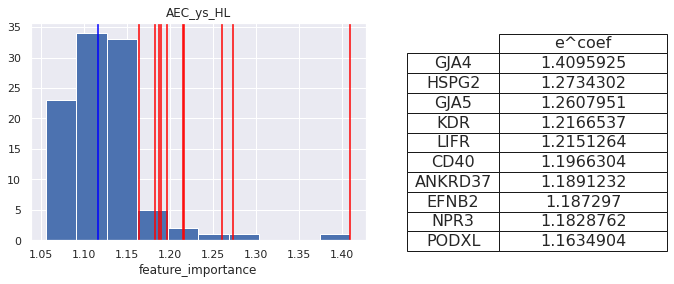

In [13]:
for classes in ['AEC_ys_HL']:
    model_class_feature_plots(top_loadings, [str(classes)], 'e^coef')
    plt.show()

/home/jovyan/my-conda-envs/workhorse/lib/python3.8/site-packages/anndata/_core/anndata.py:1235: ImplicitModificationWarning: Trying to modify attribute `.obs` of view, initializing view as actual.
  df[key] = c


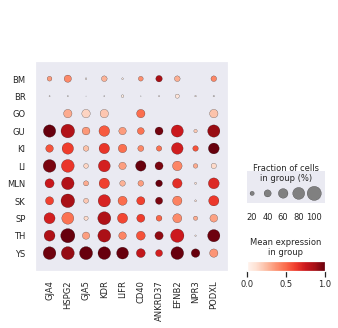

In [30]:
sc.pl.dotplot(adata[adata.obs['predicted'].isin(['AEC_ys_HL'])], groupby = 'organ', var_names = list(top_loadings.loc[top_loadings['class'].isin(['AEC_ys_HL']),'feature'].head(10)),standard_scale='var')

# Estimating dataset-specific Feature importance
 - let's also now consider the intersect between model and projected data

# Let's calculate an impact and specificty score for each cell

- We create a variable model impact factor by multiplying gene x model coeficient for class
- This is the variable contribution of each feature for a class prediction given a model and data

$X = $$\begin{bmatrix}(e^{coeff}_{n} * g1),(e^{coeff}_{n} * g2) \\ (e^{coeff}_{n} * g1),(e^{coeff}_{n} * g2) \\ (e^{coeff}_{n} * g1),(e^{coeff}_{n} * g2) \\ ..... \end{bmatrix}$

- We create a summed feature impact score for each cell by summing per feature ipact scores which identifies the overarching impact of a model's contribution.. == total model impact score

$Impact_{cellx} = $$\begin{bmatrix}(e^{coeff}_{n} * g1) + \ (e^{coeff}_{n} * g2) \ +(e^{coeff}_{n} * g3) \ + ..... \end{bmatrix}$

- We measure the model feature effect on class decisoion betwene organs and withi organs
- We can now use these feature availability/impact metrics to compare the availability and differential impact of features between data

In [32]:
from scipy import sparse

# temp
var = 'predicted'
adata_model = adata[:,list(adata_temp.var.index)]
adata_model.obs['model_topn_feature_impact'] = 0

#loop
long_format = top_loadings
for class_temp in model.classes_:
    adata_model[adata_model.obs[var].isin([class_temp])].X= sparse.csr_matrix((np.multiply((adata_model[adata_model.obs[var].isin([class_temp])].X.todense()),np.array(mat.loc[class_temp]))))
    # Impact of top n features
    adata_model.obs.loc[adata_model.obs[var].isin([class_temp]),'model_topn_feature_impact'] = np.log(np.sum(np.multiply(adata_model[adata_model.obs[var].isin([class_temp])][:,list(long_format[long_format['class'].isin([class_temp])].feature)].X.todense(), np.array(long_format[long_format['class'].isin([class_temp])]['e^coef'])),axis =1))
# Total impact of all model features
adata_model.obs['model_class_impact_total'] = np.log([item for sublist in (np.sum(adata_model.X,axis=1)).tolist() for item in sublist])
adata_model.obs[['model_topn_feature_impact','model_class_impact_total']]

<ipython-input-32-b91090693e07>:6: ImplicitModificationWarning: Trying to modify attribute `.obs` of view, initializing view as actual.
  adata_model.obs['model_topn_feature_impact'] = 0
<ipython-input-32-b91090693e07>:13: RuntimeWarning: divide by zero encountered in log
  adata_model.obs.loc[adata_model.obs[var].isin([class_temp]),'model_topn_feature_impact'] = np.log(np.sum(np.multiply(adata_model[adata_model.obs[var].isin([class_temp])][:,list(long_format[long_format['class'].isin([class_temp])].feature)].X.todense(), np.array(long_format[long_format['class'].isin([class_temp])]['e^coef'])),axis =1))
<ipython-input-32-b91090693e07>:15: RuntimeWarning: divide by zero encountered in log
  adata_model.obs['model_class_impact_total'] = np.log([item for sublist in (np.sum(adata_model.X,axis=1)).tolist() for item in sublist])
<ipython-input-32-b91090693e07>:15: PerformanceWarning: DataFrame is highly fragmented.  This is usually the result of calling `frame.insert` many times, which has 

model_topn_feature_impact  \
FCAImmP7579224-ATTACTCTCGATGAGG                    5.567179   
FCAImmP7579224-CAGCCGAGTACATCCA                    5.333402   
FCAImmP7579224-TGCTACCTCATGTAGC                    5.023268   
FCAImmP7579224-ACGGCCACAAGCTGAG                    5.515850   
FCAImmP7579224-CTAATGGCACTGTGTA                    4.806668   
...                                                     ...   
HD_F_GON9883868_TCCCGATTCATCGATG                   4.253328   
HD_F_GON9883868_TGACGGCCATGACATC                   2.342999   
HD_F_GON9883868_TGCGTGGCACACATGT                   3.870468   
HD_F_GON9883868_TGGACGCAGAAGGCCT                   3.517403   
HD_F_GON9883868_TTCCCAGGTATCACCA                   4.178838   

                                  model_class_impact_total  
FCAImmP7579224-ATTACTCTCGATGAGG                   6.897207  
FCAImmP7579224-CAGCCGAGTACATCCA                   6.520750  
FCAImmP7579224-TGCTACCTCATGTAGC                   6.488607  
FCAImmP7579224-ACGGCCACAAGCTGAG                   6.977740  
FCAImmP7579224-CTAATGGCACTGTGTA                   6.336239  
...                                                    ...  
HD_F_GON9883868_TCCCGATTCATCGATG                  5.097302  
HD_F_GON9883868_TGACGGCCATGACATC                  3.458170  
HD_F_GON9883868_TGCGTGGCACACATGT                  5.169761  
HD_F_GON9883868_TGGACGCAGAAGGCCT                  4.682687  
HD_F_GON9883868_TTCCCAGGTATCACCA                  5.685883  

[1512826 rows x 2 columns]

# Apply above to the atlas integrated data

# Also calulate particularly the impact of top features predicted by the model in each data

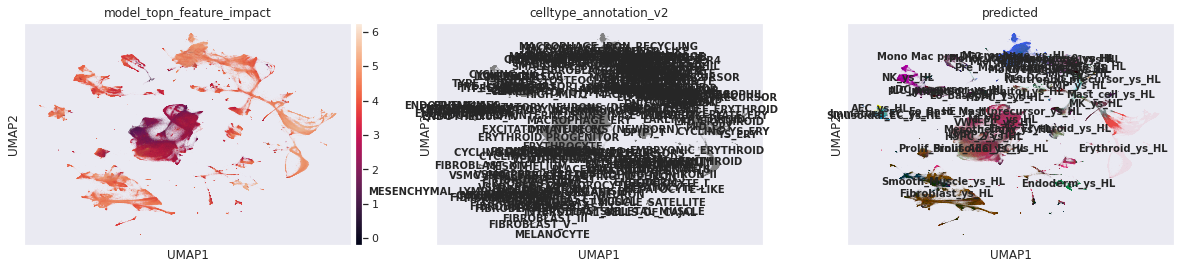

In [34]:
sc.pl.umap(adata_model,color =[ 'model_topn_feature_impact','celltype_annotation_v2','predicted'],legend_loc = 'on data')

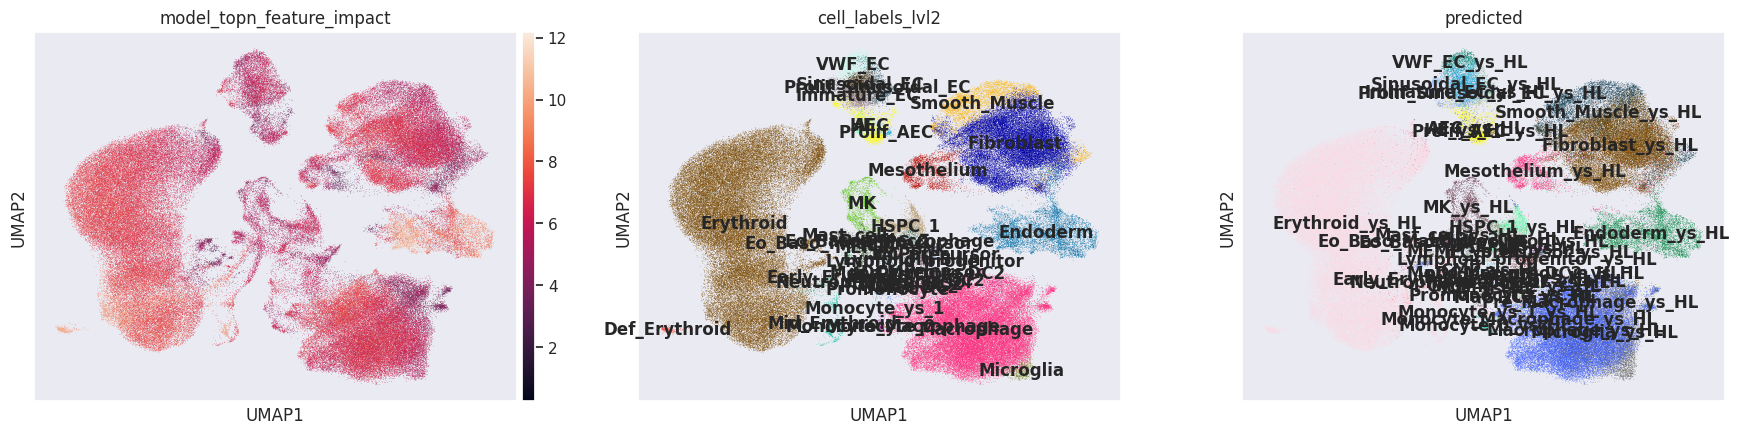

In [18]:
sc.pl.umap(adata_model,color =[ 'model_topn_feature_impact','cell_labels_lvl2','predicted'],legend_loc = 'on data')

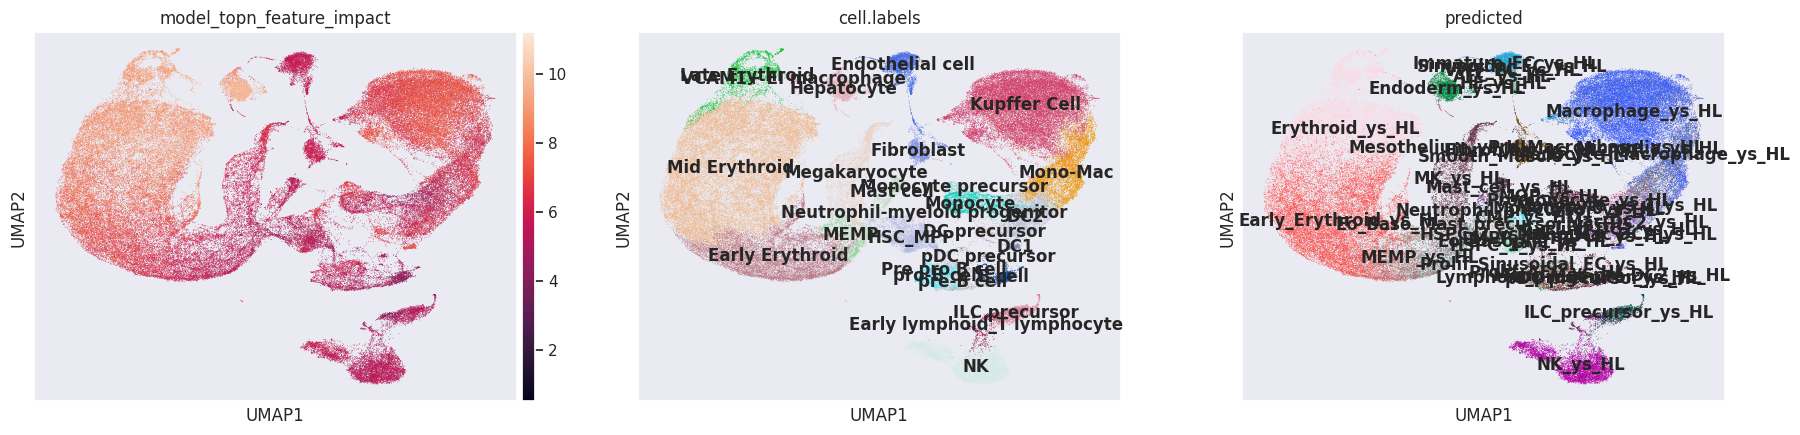

In [7]:
sc.pl.umap(adata_model,color =[ 'model_topn_feature_impact','cell.labels','predicted'],legend_loc = 'on data')

# Calculate differential model feature impact

6


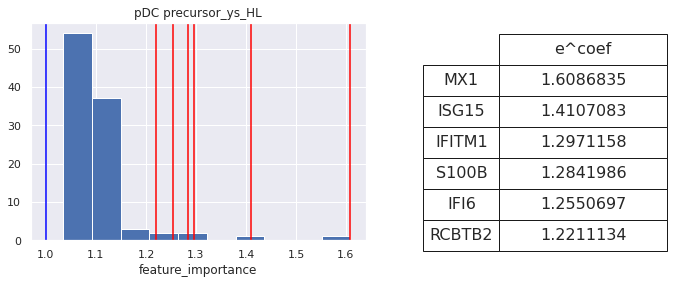

10


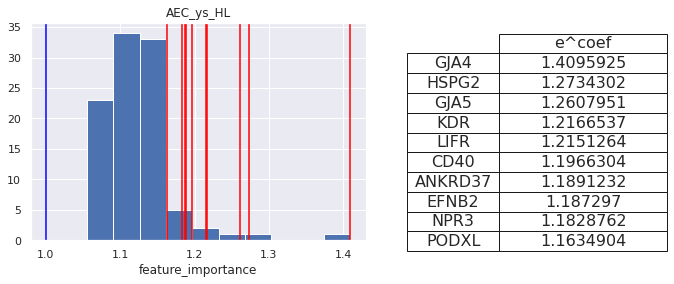

In [136]:
# Estimate dataset specific feature impact
for classes in ['pDC precursor_ys_HL','AEC_ys_HL']:
    model_class_feature_plots(top_loadings, [str(classes)], 'e^coef')
    plt.show()

# Create-desegregated datasets for cross-data per class prediction feature impact
- feature impact is computed above and top features for each model class are recorded below

In [ ]:
adatas = {}

for data in adata.obs[split].unique():
    adatas[split] = adata[adata.obs[split].isin([data])]

In [45]:
split = 'predicted'
data = ['Macrophage_ys_HL']
adatas = {}
adatas[split] = adata_model[adata_model.obs[split].isin(data)]

/home/jovyan/my-conda-envs/workhorse/lib/python3.8/site-packages/anndata/compat/_overloaded_dict.py:106: ImplicitModificationWarning: Trying to modify attribute `._uns` of view, initializing view as actual.
  self.data[key] = value


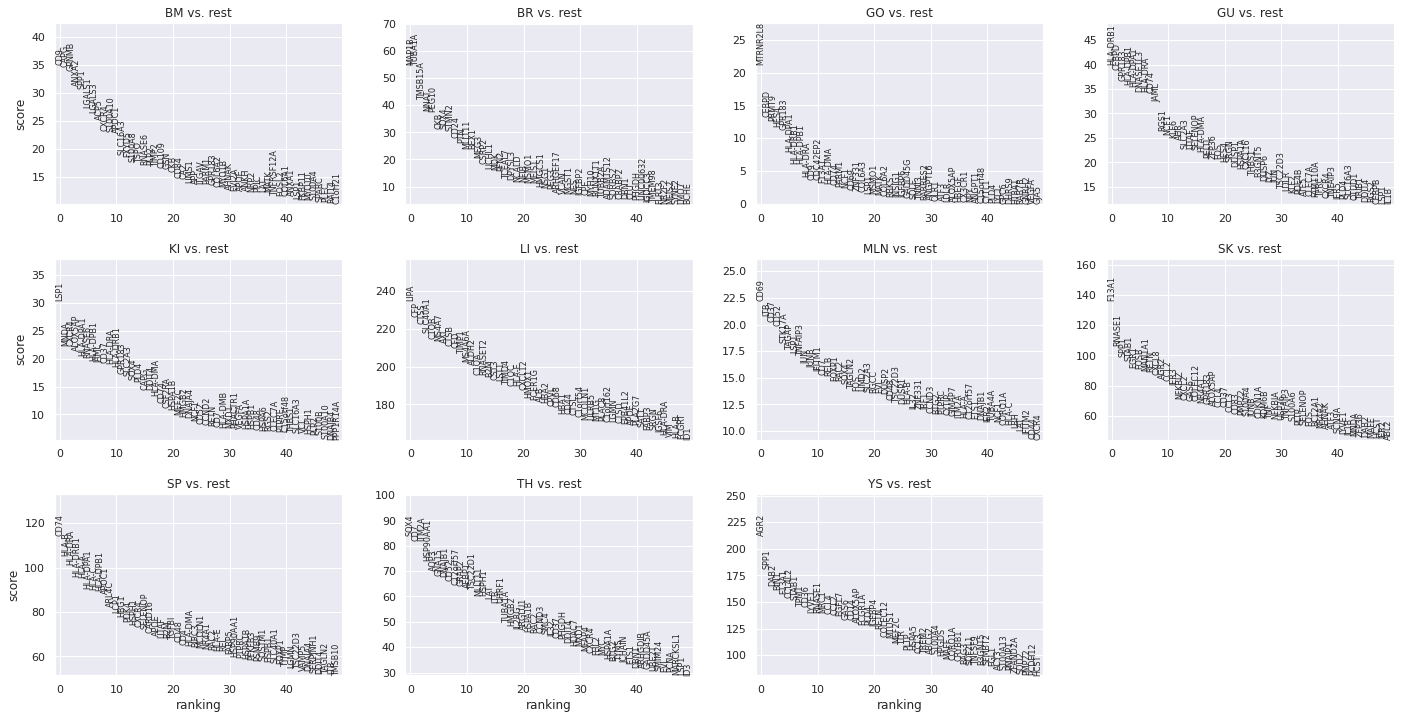

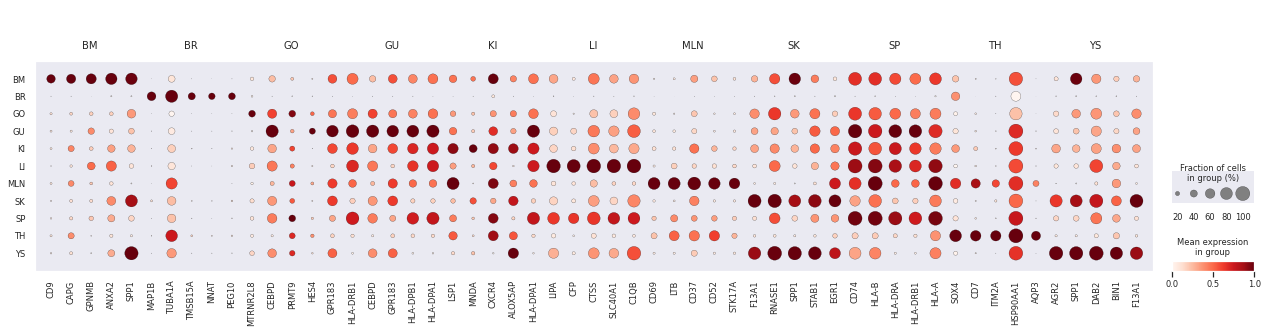

In [46]:
spot_var = 'organ'
sc.tl.rank_genes_groups(adatas[split], spot_var, method='wilcoxon',n_genes=500)
sc.pl.rank_genes_groups(adatas[split], n_genes=50, sharey=False)
result = adatas[split].uns['rank_genes_groups']
groups = result['names'].dtype.names
    
DE = pd.DataFrame(
    {group + '_' + key[:1]: result[key][group]
    for group in groups for key in ['names', 'pvals','logfoldchanges']}).head(500)
DE_name =(spot_var + ".csv")
DE.to_csv(DE_name)
degs = DE[:]
if 'concat' in locals() or 'concat' in globals():
    del(concat)
n = degs.loc[:, degs.columns.str.endswith("_n")]
n = pd.melt(n)
p = degs.loc[:, degs.columns.str.endswith("_p")]
p = pd.melt(p)
l = degs.loc[:, degs.columns.str.endswith("_l")]
l = pd.melt(l)
n = n.replace(regex=r'_n', value='')
n = n.rename(columns={"variable": "cluster", "value": "gene"})
p = (p.drop(["variable"],axis = 1)).rename(columns={ "value": "p_val"})
l = (l.drop(["variable"],axis = 1)).rename(columns={ "value": "logfc"})
concat = pd.concat([n,p,l],axis=1)
#remove mito genes from data
concat = concat[~concat["gene"].str.startswith("MT-")]
concat = concat[~concat["gene"].str.startswith("RP11-")]
concat["cluster"] = concat["cluster"].astype(str)
marker_df = concat.groupby('cluster').apply(lambda grp: grp.nsmallest(5, 'p_val')).reset_index(drop=True)
markers = marker_df.groupby('cluster')['gene'].apply(list).to_dict()
markers = dict(sorted(markers.items()))
markers = {str(k):v for k,v in markers.items()}
data_temp = adatas[split]
markers = markers
(sc.pl.dotplot(data_temp, var_names = markers, groupby=spot_var,dendrogram=False,standard_scale='var', color_map='Reds', show = True, save = 'diff_organ_mhcIImac.pdf')) # title=i

# Betweeb class feqatures vs within class features -- descrimniatory

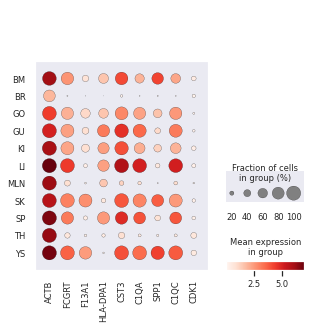

In [59]:
sc.pl.dotplot(data_temp, groupby = spot_var, var_names = list(top_loadings[(top_loadings['class'].isin(data))& (top_loadings['is_significant_sf']==True)]['feature']))

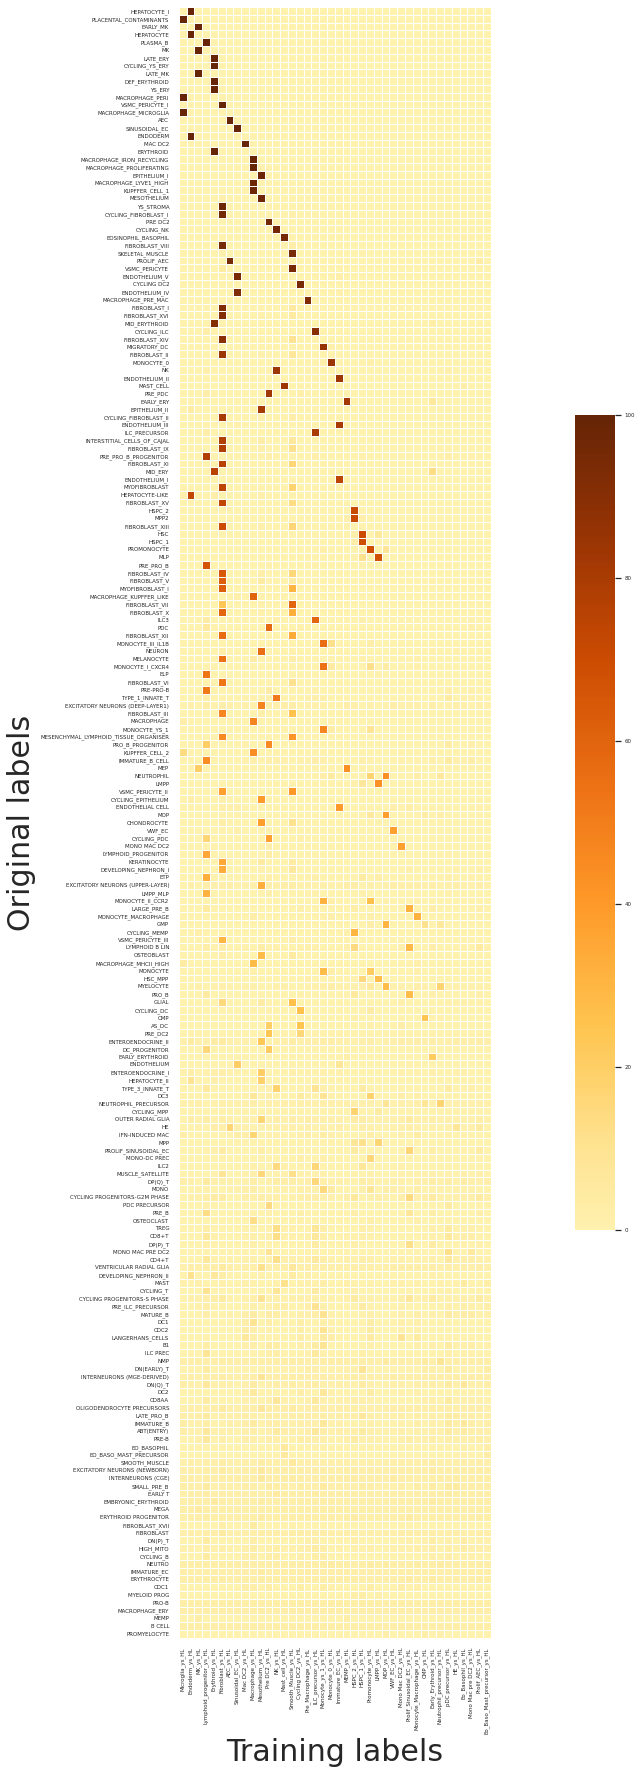

<Figure size 432x288 with 0 Axes>

In [62]:
model_mean_probs = pred_out.loc[:, pred_out.columns != 'consensus_clus_prediction'].groupby('orig_labels').median()
model_mean_probs = model_mean_probs*100
model_mean_probs = model_mean_probs.dropna(axis=0, how='any', thresh=None, subset=None, inplace=False)
crs_tbl = model_mean_probs.copy()

# Sort df columns by rows
index_order = list(crs_tbl.max(axis=1).sort_values(ascending=False).index)
col_order = list(crs_tbl.max(axis=0).sort_values(ascending=False).index)
crs_tbl = crs_tbl.loc[index_order]
crs_tbl = crs_tbl[col_order]

# Plot_df_heatmap(crs_tbl, cmap='coolwarm', rotation=90, vmin=20, vmax=70)
pal = sns.color_palette("YlOrBr", as_cmap=True)#sns.color_palette("magma", as_cmap=True)#sns.diverging_palette(240, 10, n=10)
plt.figure(figsize=(30,30))
sns.set(font_scale=0.5)
g = sns.heatmap(crs_tbl, cmap=pal,  annot=False,vmin=0, vmax=100, linewidths=1, center=40, square=True, cbar_kws={"shrink": 0.5})

plt.ylabel("Original labels", fontsize=30)
plt.xlabel("Training labels", fontsize=30)
plt.show()
plt.savefig('./ver5_lr_model_means_subclusters.pdf',dpi=300)

# Quick outs QC

In [15]:
# unique pairing counter

#Input columns of interest
var = [freq_redist,"consensus_clus_prediction"]
obs = adata.obs
#get date
from datetime import date
today = date.today()
d1 = (today.strftime("%d/%m/%Y")).replace("/", "_")
# #create df
# annot_sheet = obs[var]
# #annot_sheet = adata.obs[["090920_LJ_lvl1","090920_lvl2_leiden_restricted"]]
# #Drop df suplicates
# annot_sheet = annot_sheet.drop_duplicates()
# annot_sheet = annot_sheet.sort_values(by=var[0])
# annot_sheet = annot_sheet.reset_index(drop=True)
# #Create annotation cat
# for i in var:
#     #Count variates
#     prop = obs.groupby(i).count()
#     dic = dict(zip(prop.index,prop.iloc[:,0]))
#     count_name = "count_" + i 
#     annot_sheet[count_name]=annot_sheet[i].map(dic)
counts = (pd.DataFrame(obs.groupby(var).size()))
counts = counts.loc[~(counts==0).all(axis=1)].reset_index()
var.append('counts')
counts.columns = var
    
#     p = i + "_annot_" + d1
#     print(p)
#     annot_sheet[p] = ""

counts.to_csv("./lvl1_matched_liv_projected_annot.csv")
counts_top = counts.groupby([freq_redist]).apply(lambda x: x.sort_values(["counts"], ascending = False)).reset_index(drop=True).groupby([freq_redist]).head(10)
counts_top.to_csv("./top_lvl1_matched_liv_projected_annot.csv")
counts_top

cell_labels_lvl2     consensus_clus_prediction  counts
0                      AEC                     AEC_ys_HL    1707
1                      CMP                     CMP_ys_HL      25
2              Cycling DC2             Cycling DC2_ys_HL      81
3            Def_Erythroid               Erythroid_ys_HL     289
4          Early_Erythroid         Early_Erythroid_ys_HL     699
5                 Endoderm                Endoderm_ys_HL    7656
6   Eo_Baso_Mast_precursor  Eo_Baso_Mast_precursor_ys_HL      56
7              Eo_Basophil             Eo_Basophil_ys_HL      93
8                Erythroid               Erythroid_ys_HL   61038
9               Fibroblast              Fibroblast_ys_HL   28730
10                      HE                     AEC_ys_HL     199
11                      HE                      HE_ys_HL     115
12                  HSPC_1                  HSPC_1_ys_HL    2158
13                  HSPC_2                  HSPC_2_ys_HL     800
14                  HSPC_2                  HSPC_1_ys_HL     182
15           ILC_precursor           ILC_precursor_ys_HL     131
16           ILC_precursor     Lymphoid_progenitor_ys_HL      54
17             Immature_EC             Immature_EC_ys_HL    1093
18             Immature_EC           Sinusoidal_EC_ys_HL     393
19                    LMPP                    LMPP_ys_HL     169
20          Lymphoid B lin     Lymphoid_progenitor_ys_HL     152
21     Lymphoid_progenitor     Lymphoid_progenitor_ys_HL     605
22                    MEMP                    MEMP_ys_HL     762
23                      MK                      MK_ys_HL    2044
24                     MOP                     MOP_ys_HL     156
25                     MOP             Promonocyte_ys_HL      55
26                 Mac DC2                 Mac DC2_ys_HL      60
27              Macrophage              Macrophage_ys_HL   36189
28              Macrophage               Microglia_ys_HL    8224
29               Mast_cell               Mast_cell_ys_HL     354
30             Mesothelium             Mesothelium_ys_HL    2750
31               Microglia               Microglia_ys_HL     613
32           Mid_Erythroid               Erythroid_ys_HL     638
33            Mono Mac DC2            Mono Mac DC2_ys_HL      81
34            Mono Mac DC2                 Pre DC2_ys_HL      18
35        Mono Mac pre DC2                 Pre DC2_ys_HL      50
36        Mono Mac pre DC2        Mono Mac pre DC2_ys_HL      18
37              Monocyte_0              Monocyte_0_ys_HL     200
38     Monocyte_Macrophage     Monocyte_Macrophage_ys_HL      63
39           Monocyte_ys_1           Monocyte_ys_1_ys_HL     176
40                      NK                      NK_ys_HL     170
41    Neutrophil_precursor    Neutrophil_precursor_ys_HL      51
42                 Pre DC2                 Pre DC2_ys_HL     238
43          Pre_Macrophage          Pre_Macrophage_ys_HL      29
44              Prolif_AEC              Prolif_AEC_ys_HL     181
45    Prolif_Sinusoidal_EC    Prolif_Sinusoidal_EC_ys_HL    1219
46             Promonocyte             Promonocyte_ys_HL      93
47             Promonocyte                     MOP_ys_HL      42
48           Sinusoidal_EC           Sinusoidal_EC_ys_HL    1772
49           Smooth_Muscle           Smooth_Muscle_ys_HL    5106
50                  VWF_EC                  VWF_EC_ys_HL    1620
51           pDC precursor           pDC precursor_ys_HL      97

In [16]:
pred_out.loc[:, pred_out.columns != 'consensus_clus_prediction'].groupby('orig_labels').max()

predicted  AEC_ys_HL  CMP_ys_HL  \
orig_labels                                                                
AEC                                   VWF_EC_ys_HL   1.000000   0.041842   
CMP                     Neutrophil_precursor_ys_HL   0.006758   0.999531   
Cycling DC2                          Pre DC2_ys_HL   0.021180   0.024463   
Def_Erythroid                      Erythroid_ys_HL   0.029557   0.013399   
Early_Erythroid         Prolif_Sinusoidal_EC_ys_HL   0.015907   0.051873   
Endoderm                              VWF_EC_ys_HL   0.711276   0.090394   
Eo_Baso_Mast_precursor             Mast_cell_ys_HL   0.012207   0.026761   
Eo_Basophil                        Mast_cell_ys_HL   0.006231   0.003664   
Erythroid                             VWF_EC_ys_HL   0.067287   0.065156   
Fibroblast                     pDC precursor_ys_HL   0.050152   0.073757   
HE                                    VWF_EC_ys_HL   1.000000   0.034276   
HSPC_1                         pDC precursor_ys_HL   0.898489   0.993484   
HSPC_2                         pDC precursor_ys_HL   0.045610   1.000000   
ILC_precursor                  pDC precursor_ys_HL   0.006712   0.020742   
Immature_EC                           VWF_EC_ys_HL   0.999996   0.050357   
LMPP                                 Pre DC2_ys_HL   0.019922   0.993774   
Lymphoid B lin                 pDC precursor_ys_HL   0.008196   0.073643   
Lymphoid_progenitor            pDC precursor_ys_HL   0.037316   0.712972   
MEMP                    Prolif_Sinusoidal_EC_ys_HL   0.010579   0.484881   
MK                                    VWF_EC_ys_HL   0.042140   0.046767   
MOP                              Promonocyte_ys_HL   0.018032   1.000000   
Mac DC2                 Prolif_Sinusoidal_EC_ys_HL   0.003259   0.016690   
Macrophage                     pDC precursor_ys_HL   0.982781   0.997455   
Mast_cell                      Monocyte_ys_1_ys_HL   0.026416   0.039515   
Mesothelium                           VWF_EC_ys_HL   0.795147   0.052308   
Microglia                Monocyte_Macrophage_ys_HL   0.024976   0.030138   
Mid_Erythroid           Prolif_Sinusoidal_EC_ys_HL   0.017460   0.021992   
Mono Mac DC2                   pDC precursor_ys_HL   0.049403   0.033745   
Mono Mac pre DC2               pDC precursor_ys_HL   0.037576   0.041682   
Monocyte_0                     pDC precursor_ys_HL   0.001809   0.002346   
Monocyte_Macrophage            Monocyte_ys_1_ys_HL   0.014060   0.024895   
Monocyte_ys_1                    Promonocyte_ys_HL   0.005140   0.007954   
NK                                   Pre DC2_ys_HL   0.025089   0.405222   
Neutrophil_precursor             Promonocyte_ys_HL   0.020733   0.300323   
Pre DC2                        pDC precursor_ys_HL   0.002842   0.014058   
Pre_Macrophage          Prolif_Sinusoidal_EC_ys_HL   0.033171   0.015662   
Prolif_AEC                       Promonocyte_ys_HL   1.000000   0.006659   
Prolif_Sinusoidal_EC                  VWF_EC_ys_HL   0.999993   0.027533   
Promonocyte                    pDC precursor_ys_HL   0.005592   0.993779   
Sinusoidal_EC                  pDC precursor_ys_HL   0.999993   0.024493   
Smooth_Muscle                  Smooth_Muscle_ys_HL   0.036976   0.047903   
VWF_EC                                VWF_EC_ys_HL   0.947624   0.020995   
pDC precursor                  pDC precursor_ys_HL   0.009160   0.005778   

                        Cycling DC2_ys_HL  Early_Erythroid_ys_HL  \
orig_labels                                                        
AEC                              0.034242               0.080848   
CMP                              0.013637               0.009720   
Cycling DC2                      1.000000               0.068045   
Def_Erythroid                    0.011355               0.106070   
Early_Erythroid                  0.047225               1.000000   
Endoderm                         0.080017               0.914365   
Eo_Baso_Mast_precursor           0.037152               0.246437   
Eo_Basop

In [ ]:
pred_out = pred_out.drop(['predicted'],axis=1)

In [ ]:
import seaborn as sns; sns.set_theme()
sns.palplot(sns.light_palette("red"))

In [ ]:
model_mean_probs = pred_out.loc[:, pred_out.columns != 'consensus_clus_prediction'].groupby('orig_labels').median()
model_mean_probs = model_mean_probs*100
model_mean_probs = model_mean_probs.dropna(axis=0, how='any', thresh=None, subset=None, inplace=False)
crs_tbl = model_mean_probs.copy()

# Sort df columns by rows
index_order = list(crs_tbl.max(axis=1).sort_values(ascending=False).index)
col_order = list(crs_tbl.max(axis=0).sort_values(ascending=False).index)
crs_tbl = crs_tbl.loc[index_order]
crs_tbl = crs_tbl[col_order]

# Plot_df_heatmap(crs_tbl, cmap='coolwarm', rotation=90, vmin=20, vmax=70)
pal = sns.color_palette("YlOrBr", as_cmap=True)#sns.color_palette("magma", as_cmap=True)#sns.diverging_palette(240, 10, n=10)
plt.figure(figsize=(30,30))
sns.set(font_scale=1)
g = sns.heatmap(crs_tbl, cmap=pal,  annot=False,vmin=0, vmax=100, linewidths=1, center=40, square=True, cbar_kws={"shrink": 0.5})

plt.ylabel("Original labels", fontsize=30)
plt.xlabel("Training labels", fontsize=30)
plt.show()
plt.savefig('./ver5_lr_model_means_subclusters.pdf',dpi=300)

In [ ]:
crs_tbl = crs_tbl.drop(['MOP_ys_HL',
 'Mono Mac pre DC2_ys_HL',
 'HE_ys_HL',
 'ILC_precursor_ys_HL',
 'Eo_Baso_Mast_precursor_ys_HL','Mono Mac DC2_ys_HL'],axis=1)
crs_tbl = crs_tbl.drop([ 'Mono Mac DC2',
 'MOP',
 'Eo_Baso_Mast_precursor',
 'Mono Mac pre DC2',
 'HE',
 'ILC_precursor'],axis=0)

In [ ]:
# Plot_df_heatmap(crs_tbl, cmap='coolwarm', rotation=90, vmin=20, vmax=70)
pal = sns.color_palette("YlOrBr", as_cmap=True)#sns.color_palette("magma", as_cmap=True)#sns.diverging_palette(240, 10, n=10)
plt.figure(figsize=(30,30))
sns.set(font_scale=2)
g = sns.heatmap(crs_tbl, cmap=pal,  annot=False,vmin=0, vmax=100, linewidths=1, center=40, square=True, cbar_kws={"shrink": 0.5})

plt.ylabel("YS cite-seq classes", fontsize=30)
plt.xlabel("YS Training labels", fontsize=30)
plt.savefig('./ver5_lr_model_means_subclusters.pdf',dpi=300,bbox_inches='tight',)
plt.show()

In [ ]:
# sc.pl.umap(adata,color = 'cell.labels')
# sc.pl.umap(adata,color = 'consensus_clus_prediction')

# F1 weighted precision score
- This estimates the label robustness in the applied dataset

In [128]:
model = load_models(models,model_key)
model_lr= model

In [129]:
train_x = train_x
train_label = adata.obs['predicted']

In [ ]:
def report_f1(model,train_x, train_label):
    ## Report accuracy score
    from sklearn.model_selection import cross_val_score
    from sklearn.model_selection import RepeatedStratifiedKFold
    from sklearn import metrics
    import seaborn as sn
    import pandas as pd
    from sklearn.metrics import confusion_matrix
    import matplotlib.pyplot as plt
    
    # cv = RepeatedStratifiedKFold(n_splits=2, n_repeats=2, random_state=1)
    # # evaluate the model and collect the scores
    # n_scores = cross_val_score(lr, train_x, train_label, scoring='accuracy', cv=cv, n_jobs=-1)
    # # report the model performance
    # print('Mean Accuracy: %.3f (%.3f)' % (np.mean(n_scores), np.std(n_scores)))

    # Report Precision score
    metric = pd.DataFrame((metrics.classification_report(train_label, model.predict(train_x), digits=2,output_dict=True))).T
    cm = confusion_matrix(train_label, model.predict(train_x))
    #cm = confusion_matrix(train_label, model.predict_proba(train_x))
    df_cm = pd.DataFrame(cm, index = lr.classes_,columns = lr.classes_)
    df_cm = (df_cm / df_cm.sum(axis=0))*100
    plt.figure(figsize = (20,15))
    sn.set(font_scale=1) # for label size
    pal = sns.diverging_palette(240, 10, n=10)
    #plt.suptitle(('Mean Accuracy 5 fold: %.3f std: %.3f' % (np.mean(n_scores),  np.std(n_scores))), y=1.05, fontsize=18)
    #Plot precision recall and recall
    table = plt.table(cellText=metric.values,colWidths = [1]*len(metric.columns),
    rowLabels=metric.index,
    colLabels=metric.columns,
    cellLoc = 'center', rowLoc = 'center',
    loc='bottom', bbox=[0.25, -0.6, 0.5, 0.3])
    table.scale(1, 2)
    table.set_fontsize(16)

    sn.heatmap(df_cm, annot=True, annot_kws={"size": 16},cmap=pal) # font size
    print(metrics.classification_report(train_label, model.predict(train_x), digits=2))

In [132]:
## Report accuracy score
from sklearn.model_selection import cross_val_score
from sklearn.model_selection import RepeatedStratifiedKFold
from sklearn import metrics
import seaborn as sn
import pandas as pd
from sklearn.metrics import confusion_matrix
import matplotlib.pyplot as plt

lr = model_lr
# cv = RepeatedStratifiedKFold(n_splits=2, n_repeats=2, random_state=1)
# # evaluate the model and collect the scores
# n_scores = cross_val_score(lr, train_x, train_label, scoring='accuracy', cv=cv, n_jobs=-1)
# # report the model performance
# print('Mean Accuracy: %.3f (%.3f)' % (np.mean(n_scores), np.std(n_scores)))

# Report Precision score
metric = pd.DataFrame((metrics.classification_report(train_label, model.predict(train_x), digits=2,output_dict=True))).T

cm = confusion_matrix(train_label, model.predict(train_x))
#cm = confusion_matrix(train_label, model.predict_proba(train_x))

df_cm = pd.DataFrame(cm, index = lr.classes_,
                  columns = lr.classes_)
df_cm = (df_cm / df_cm.sum(axis=0))*100
plt.figure(figsize = (20,15))
sn.set(font_scale=1) # for label size
pal = sns.diverging_palette(240, 10, n=10)
#plt.suptitle(('Mean Accuracy 5 fold: %.3f std: %.3f' % (np.mean(n_scores),  np.std(n_scores))), y=1.05, fontsize=18)

#Plot precision recall and recall
table = plt.table(cellText=metric.values,colWidths = [1]*len(metric.columns),
rowLabels=metric.index,
colLabels=metric.columns,
cellLoc = 'center', rowLoc = 'center',
loc='bottom', bbox=[0.25, -0.6, 0.5, 0.3])
table.scale(1, 2)
table.set_fontsize(16)

sn.heatmap(df_cm, annot=True, annot_kws={"size": 16},cmap=pal) # font size
print(metrics.classification_report(train_label, model.predict(train_x), digits=2))

ValueError: X has 1208 features, but LogisticRegression is expecting 1209 features as input.

# Calculate ROC AUC of projection

In [ ]:
# roc curve and auc
from sklearn.datasets import make_classification
from sklearn.linear_model import LogisticRegression
from sklearn.model_selection import train_test_split
from sklearn.metrics import roc_curve
from sklearn.metrics import roc_auc_score
from matplotlib import pyplot
# generate 2 class dataset
X, y = make_classification(n_samples=1000, n_classes=2, random_state=1)
# split into train/test sets
trainX, testX, trainy, testy = train_test_split(X, y, test_size=0.5, random_state=2)
# generate a no skill prediction (majority class)
ns_probs = [0 for _ in range(len(testy))]
# fit a model
model = LogisticRegression(solver='lbfgs')
model.fit(trainX, trainy)
# predict probabilities
lr_probs = model.predict_proba(testX)
# keep probabilities for the positive outcome only
lr_probs = lr_probs[:, 1]
# calculate scores
ns_auc = roc_auc_score(testy, ns_probs)
lr_auc = roc_auc_score(testy, lr_probs)
# summarize scores
print('No Skill: ROC AUC=%.3f' % (ns_auc))
print('Logistic: ROC AUC=%.3f' % (lr_auc))
# calculate roc curves
ns_fpr, ns_tpr, _ = roc_curve(testy, ns_probs)
lr_fpr, lr_tpr, _ = roc_curve(testy, lr_probs)
# plot the roc curve for the model
pyplot.plot(ns_fpr, ns_tpr, linestyle='--', label='No Skill')
pyplot.plot(lr_fpr, lr_tpr, marker='.', label='Logistic')
# axis labels
pyplot.xlabel('False Positive Rate', fontsize=20)
pyplot.ylabel('True Positive Rate', fontsize=20)
# show the legend
pyplot.legend()
# show the plot
pyplot.show()

# Dev portions

# Feature importance (.X)

In [157]:
model = load_models(models,model_key)
# model = model['Model']
adata =  load_adatas(adatas_dict, data_merge, adata_key)

In [11]:
### Feature importance notes
#- If we increase the x feature one unit, then the prediction will change e to the power of its weight. We can apply this rule to the all weights to find the feature importance.
#- We will calculate the Euler number to the power of its coefficient to find the importance.
#- To sum up an increase of x feature by one unit increases the odds of being versicolor class by a factor of x[importance] when all other features remain the same.

#- For low-dim, we look at the distribution of e^coef per class, we extract the 

import itertools
import math
import warnings

# class coef_extract:
#     def __init__(self, model,features, pos):
# #         self.w = list(itertools.chain(*(model.coef_[pos]).tolist())) #model.coef_[pos]
#         self.w = model.coef_[class_pred_pos]
#         self.features = features 

model_lr = model#['Model']

def long_format_features(top_loadings):
    p = top_loadings.loc[:, top_loadings.columns.str.endswith("_e^coef")]
    p = pd.melt(p)
    n = top_loadings.loc[:, top_loadings.columns.str.endswith("_feature")]
    n = pd.melt(n)
    l = top_loadings.loc[:, top_loadings.columns.str.endswith("_coef")]
    l = pd.melt(l)
    n = n.replace(regex=r'_feature', value='')
    n = n.rename(columns={"variable": "class", "value": "feature"})
    p = (p.drop(["variable"],axis = 1)).rename(columns={ "value": "e^coef"})
    l = (l.drop(["variable"],axis = 1)).rename(columns={ "value": "coef"})
    concat = pd.concat([n,p,l],axis=1)
    return concat

class estimate_important_features:
    def __init__(self, model, top_n):
        print('Estimating feature importance')
        classes =  list(model.classes_)
         # get feature names
        try:
            model_features = list(itertools.chain(*list(model.features)))
        except:
            warnings.warn('no features recorded in data, naming features by position')
            print('if low-dim lr was submitted, run linear decoding function to obtain true feature set')
            model_features = list(range(0,model.coef_.shape[1]))
            model.features = model_features
        print('Calculating the Euler number to the power of coefficients')
        impt_ = pow(math.e,model.coef_)
        try:
            self.euler_pow_mat = pd.DataFrame(impt_,columns = list(itertools.chain(*list(model.features))),index = list(model.classes_))
        except:
            self.euler_pow_mat = pd.DataFrame(impt_,columns = list(model.features),index = list(model.classes_))
        self.top_n_features = pd.DataFrame(index = list(range(0,top_n)))
        # estimate per class feature importance
        
        print('Estimating feature importance for each class')
        mat = self.euler_pow_mat
        for class_pred_pos in list(range(0,len(mat.T.columns))):
            class_pred = list(mat.T.columns)[class_pred_pos]
            #     print(class_pred)
            temp_mat =  pd.DataFrame(mat.T[class_pred])
            temp_mat['coef'] = model.coef_[class_pred_pos]
            temp_mat = temp_mat.sort_values(by = [class_pred], ascending=False)
            temp_mat = temp_mat.reset_index()
            temp_mat.columns = ['feature','e^coef','coef']
            temp_mat = temp_mat[['feature','e^coef','coef']]
            temp_mat.columns =str(class_pred)+ "_" + temp_mat.columns
            self.top_n_features = pd.concat([self.top_n_features,temp_mat.head(top_n)], join="inner",ignore_index = False, axis=1) 
        
feature_importance = estimate_important_features(model_lr, 30)
mat = feature_importance.euler_pow_mat
top_loadings = feature_importance.top_n_features
long_format = long_format_features(top_loadings)
long_format

Estimating feature importance
Calculating the Euler number to the power of coefficients
Estimating feature importance for each class


class feature    e^coef      coef
0               AEC_ys_HL    GJA4  1.409593  0.343301
1               AEC_ys_HL   HSPG2  1.273430  0.241714
2               AEC_ys_HL    GJA5  1.260795  0.231743
3               AEC_ys_HL     KDR  1.216654  0.196104
4               AEC_ys_HL    LIFR  1.215126  0.194848
...                   ...     ...       ...       ...
1195  pDC precursor_ys_HL    ELK3  1.127732  0.120209
1196  pDC precursor_ys_HL  JCHAIN  1.126958  0.119522
1197  pDC precursor_ys_HL   NLRP3  1.126151  0.118806
1198  pDC precursor_ys_HL   IFRD1  1.123850  0.116761
1199  pDC precursor_ys_HL  ARGLU1  1.121814  0.114947

[1200 rows x 4 columns]

In [12]:
long_format['class'].unique()

array(['AEC_ys_HL', 'CMP_ys_HL', 'Cycling DC2_ys_HL',
       'Early_Erythroid_ys_HL', 'Endoderm_ys_HL',
       'Eo_Baso_Mast_precursor_ys_HL', 'Eo_Basophil_ys_HL',
       'Erythroid_ys_HL', 'Fibroblast_ys_HL', 'HE_ys_HL', 'HSPC_1_ys_HL',
       'HSPC_2_ys_HL', 'ILC_precursor_ys_HL', 'Immature_EC_ys_HL',
       'LMPP_ys_HL', 'Lymphoid_progenitor_ys_HL', 'MEMP_ys_HL',
       'MK_ys_HL', 'MOP_ys_HL', 'Mac DC2_ys_HL', 'Macrophage_ys_HL',
       'Mast_cell_ys_HL', 'Mesothelium_ys_HL', 'Microglia_ys_HL',
       'Mono Mac DC2_ys_HL', 'Mono Mac pre DC2_ys_HL', 'Monocyte_0_ys_HL',
       'Monocyte_Macrophage_ys_HL', 'Monocyte_ys_1_ys_HL', 'NK_ys_HL',
       'Neutrophil_precursor_ys_HL', 'Pre DC2_ys_HL',
       'Pre_Macrophage_ys_HL', 'Prolif_AEC_ys_HL',
       'Prolif_Sinusoidal_EC_ys_HL', 'Promonocyte_ys_HL',
       'Sinusoidal_EC_ys_HL', 'Smooth_Muscle_ys_HL', 'VWF_EC_ys_HL',
       'pDC precursor_ys_HL'], dtype=object)

<ipython-input-13-27217cfce5a3>:16: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  df_loadings[str(comps) +'_pval'] = pvals


5


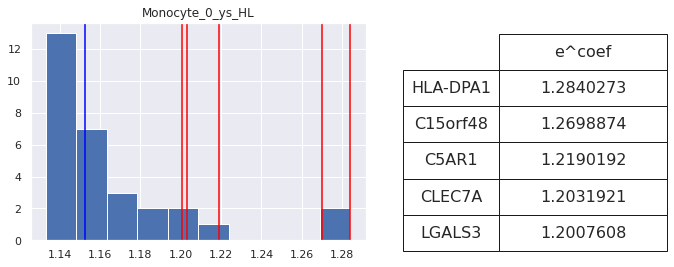

In [13]:
import matplotlib.pyplot as plt
%matplotlib inline  

class_lw = 'Monocyte_0_ys_HL'
df_loadings = long_format[long_format['class'].isin([class_lw])]
comps = 'e^coef'

U = np.mean(df_loadings[comps])
std = np.std(df_loadings[comps])
med =  np.median(df_loadings[comps])
mad = np.median(np.absolute(df_loadings[comps] - np.median(df_loadings[comps])))

# Survival function scaled by 1.4826 of MAD (approx norm)
pvals = scipy.stats.norm.sf(df_loadings[comps], loc=med, scale=1.4826*mad)
#pvals = scipy.stats.norm.sf(df_loadings[comps], loc=U, scale=1*std)
df_loadings[str(comps) +'_pval'] = pvals
plt.hist(df_loadings[comps])
for i in ((df_loadings[comps][df_loadings[str(comps) +'_pval']<0.05]).unique()):
    plt.axvline(x=i,color='red')
plt.axvline(x=med,color='blue')
plt.title(class_lw)
#plt.axvline(x=med,color='pink')
df_loadings[comps][df_loadings[str(comps) +'_pval']<0.05]
print(len(df_loadings[comps][df_loadings[str(comps) +'_pval']<0.05]))

#Plot feature ranking
plot_loading = pd.DataFrame(pd.DataFrame(df_loadings[comps][df_loadings[str(comps) +'_pval']<0.05]).iloc[:,0].sort_values(ascending=False))
table = plt.table(cellText=plot_loading.values,colWidths = [1]*len(plot_loading.columns),
rowLabels= list(df_loadings['feature'][df_loadings.index.isin(plot_loading.index)].reindex(plot_loading.index)), #plot_loading.index,
colLabels=plot_loading.columns,
cellLoc = 'center', rowLoc = 'center',
loc='right', bbox=[1.4, -0.05, 0.5,1])
table.scale(1, 2)
table.set_fontsize(16)

# Let's rank feature according to specificity of contribution goven different prediction data

In [14]:
feature_importance = estimate_important_features(model_lr, 30)
mat = feature_importance.euler_pow_mat
mat

Estimating feature importance
Calculating the Euler number to the power of coefficients
Estimating feature importance for each class


ANXA2    ADGRL4    DLGAP5      TYMS  \
AEC_ys_HL                     1.031634  1.046684  0.882486  0.828307   
CMP_ys_HL                     1.000000  1.000000  0.967349  1.014581   
Cycling DC2_ys_HL             1.000000  1.000000  1.000000  1.133149   
Early_Erythroid_ys_HL         0.967180  1.000000  1.000000  1.014218   
Endoderm_ys_HL                1.000000  1.000000  1.000000  1.000000   
Eo_Baso_Mast_precursor_ys_HL  1.007118  1.000000  1.043558  1.006995   
Eo_Basophil_ys_HL             1.000000  1.000000  1.093582  0.962942   
Erythroid_ys_HL               0.962700  1.167072  0.960049  1.046476   
Fibroblast_ys_HL              1.041453  1.026915  1.162568  0.918428   
HE_ys_HL                      0.894150  1.036620  0.993099  1.000000   
HSPC_1_ys_HL                  1.295232  0.797399  1.034215  0.988133   
HSPC_2_ys_HL                  0.794506  1.000000  1.170545  1.284057   
ILC_precursor_ys_HL           1.000000  0.969607  1.058576  0.996535   
Immature_EC_ys_HL             1.268515  1.122699  0.890702  0.949181   
LMPP_ys_HL                    0.982870  1.000000  0.886627  0.924165   
Lymphoid_progenitor_ys_HL     0.990768  1.000000  1.108962  1.000000   
MEMP_ys_HL                    1.000000  0.998246  0.903916  1.079817   
MK_ys_HL                      0.882497  1.000000  1.000000  1.058380   
MOP_ys_HL                     1.000000  1.000000  1.031747  0.997625   
Mac DC2_ys_HL                 0.952647  1.000000  0.969788  1.108147   
Macrophage_ys_HL              1.054499  0.982670  1.000000  0.848253   
Mast_cell_ys_HL               1.000000  1.000000  0.882495  0.882494   
Mesothelium_ys_HL             1.100909  1.111634  0.970489  1.041647   
Microglia_ys_HL               0.984760  0.995816  0.868412  1.007849   
Mono Mac DC2_ys_HL            1.000000  1.000000  1.000000  1.000000   
Mono Mac pre DC2_ys_HL        0.968884  1.000000  1.027732  1.000000   
Monocyte_0_ys_HL              1.010569  1.000000  1.000000  0.973367   
Monocyte_Macrophage_ys_HL     1.030134  1.000000  1.031741  0.961717   
Monocyte_ys_1_ys_HL           1.000000  1.000000  0.981509  0.977978   
NK_ys_HL                      1.000000  1.000000  1.004238  1.052170   
Neutrophil_precursor_ys_HL    1.000000  1.000000  0.994463  0.972392   
Pre DC2_ys_HL                 0.882497  1.000000  1.284035  1.131985   
Pre_Macrophage_ys_HL          0.983310  1.000000  1.000000  1.031700   
Prolif_AEC_ys_HL              0.984102  1.133155  1.046714  1.133153   
Prolif_Sinusoidal_EC_ys_HL    1.000000  1.020918  1.108281  1.642601   
Promonocyte_ys_HL             1.043385  1.000000  1.000000  1.000000   
Sinusoidal_EC_ys_HL           1.197676  1.000159  1.042887  0.822637   
Smooth_Muscle_ys_HL           0.982511  0.732565  0.825819  0.850920   
VWF_EC_ys_HL                  0.951109  1.047570  0.888965  0.824556   
pDC precursor_ys_HL           0.977935  1.000000  0.983357  1.000000   

                                 CCNB1    GLT8D2    HSPA1A    DNAJB1  \
AEC_ys_HL                     0.940391  1.000000  0.971680  1.000000   
CMP_ys_HL                     1.000000  1.000000  1.000000  0.969233   
Cycling DC2_ys_HL             0.995513  1.000000  0.907483  0.966276   
Early_Erythroid_ys_HL         1.043659  1.000000  1.049610  1.029327   
Endoderm_ys_HL                0.947111  1.000000  1.031727  1.000000   
Eo_Baso_Mast_precursor_ys_HL  1.038880  1.000000  1.012017  0.963469   
Eo_Basophil_ys_HL             1.000000  1.000000  1.129221  1.218629   
Erythroid_ys_HL               0.794846  1.034382  1.029187  1.046818   
Fibroblast_ys_HL              1.143620  0.999998  0.969740  1.109500   
HE_ys_HL                      0.883957  1.000000  1.004411  0.997720   
HSPC_1_ys_HL                  0.810117  0.974100  1.007517  0.963651   
HSPC_2_ys_HL                  1.158624  1.000000  0.797644  1.043801   
ILC_precursor_ys_HL           1.030165  1.000000  1.000000  1.000000   
Immature_EC_ys_HL             0.888796  1.103182  0.999999  1.000000   


# Let's calculate an impact and specificty score for each cell

- We create a variable model impact factor by multiplying gene x model coeficient for class

$X = $$\begin{bmatrix}(e^{coeff}_{g1} * g1) \\ (e^{coeff}_{g2} * g2) \\ (e^{coeff}_{g3} * g3) \\ ..... \end{bmatrix}$

- We create a summed feature impact score for each cell by summing per feature ipact scores which identifies the overarching impact of a model's contribution.. == total model impact score

$Impact_{cellx} = $$\begin{bmatrix}(e^{coeff}_{g1} * g1) + \ (e^{coeff}_{g2} * g2) \ +(e^{coeff}_{g3} * g3) \ + ..... \end{bmatrix}$

In [ ]:
# slice and reorder the model


In [152]:
class_temp = 'Sinusoidal_EC_ys_HL'

In [113]:
mat.T[class_temp]

ANXA2     1.197676
ADGRL4    1.000159
DLGAP5    1.042887
TYMS      0.822637
CCNB1     0.882465
            ...   
MILR1     1.028266
NR4A1     0.843473
TFPI      0.999315
FABP5     0.967501
THY1      0.882491
Name: Sinusoidal_EC_ys_HL, Length: 1209, dtype: float32

In [98]:
adata_temp

View of AnnData object with n_obs × n_vars = 2569 × 1208
    obs: 'cell.labels', 'stage', 'lanes', 'sex', 'sort.ids', 'fetal.ids', 'component', 'broad_cell.labels', 'sequencing.type', 'orig.dataset', 'broad_cell_labels_organ', 'tissue', 'V6_old_indexes', 'dataset_merge', 'index_orig', 'orig.ident', 'nCount_RNA', 'nFeature_RNA', 'percent.mito', 'organ', 'donor', 'new_data_handle', 'batch', 'HDBR_ID', 'leiden_scvi_res15', 'n_genes_by_counts', 'total_counts', 'total_counts_mt', 'pct_counts_mt', 'scrublet_score', 'scrublet_cluster_score', 'scr_bh_pval', 'scr_pval', 'scr_doublet_call_default', 'scrublet_leiden_R', 'cell_labels_lvl2', 'cell_labels_lvl3', 'cell_labels_lvl1', 'predicted', 'consensus_clus_prediction'
    var: 'n_cells-0', 'mt-0', 'total_counts-0', 'highly_variable-0', 'intersect-0', 'means-0', 'dispersions-0', 'dispersions_norm-0', 'gene_ids-3', 'feature_types-3', 'genome-3', 'n_cells', 'mt', 'n_cells_by_counts', 'mean_counts', 'pct_dropout_by_counts', 'total_counts', 'mean', '

In [93]:
X_impt_temp

<2569x1208 sparse matrix of type '<class 'numpy.float32'>'
	with 840437 stored elements in Compressed Sparse Row format>

In [73]:
X_impt_temp

<2569x19015 sparse matrix of type '<class 'numpy.float32'>'
	with 6837999 stored elements in Compressed Sparse Row format>

In [49]:
if isinstance(top_n, int) & top_n != False:
    print('Using top_n scoring')

In [36]:
top_n = False
isinstance(top_n, int)

True

In [ ]:
def cell_model_impact_score(adata, var, top_n):
    

In [22]:
mat

ANXA2    ADGRL4    DLGAP5      TYMS  \
AEC_ys_HL                     1.031634  1.046684  0.882486  0.828307   
CMP_ys_HL                     1.000000  1.000000  0.967349  1.014581   
Cycling DC2_ys_HL             1.000000  1.000000  1.000000  1.133149   
Early_Erythroid_ys_HL         0.967180  1.000000  1.000000  1.014218   
Endoderm_ys_HL                1.000000  1.000000  1.000000  1.000000   
Eo_Baso_Mast_precursor_ys_HL  1.007118  1.000000  1.043558  1.006995   
Eo_Basophil_ys_HL             1.000000  1.000000  1.093582  0.962942   
Erythroid_ys_HL               0.962700  1.167072  0.960049  1.046476   
Fibroblast_ys_HL              1.041453  1.026915  1.162568  0.918428   
HE_ys_HL                      0.894150  1.036620  0.993099  1.000000   
HSPC_1_ys_HL                  1.295232  0.797399  1.034215  0.988133   
HSPC_2_ys_HL                  0.794506  1.000000  1.170545  1.284057   
ILC_precursor_ys_HL           1.000000  0.969607  1.058576  0.996535   
Immature_EC_ys_HL             1.268515  1.122699  0.890702  0.949181   
LMPP_ys_HL                    0.982870  1.000000  0.886627  0.924165   
Lymphoid_progenitor_ys_HL     0.990768  1.000000  1.108962  1.000000   
MEMP_ys_HL                    1.000000  0.998246  0.903916  1.079817   
MK_ys_HL                      0.882497  1.000000  1.000000  1.058380   
MOP_ys_HL                     1.000000  1.000000  1.031747  0.997625   
Mac DC2_ys_HL                 0.952647  1.000000  0.969788  1.108147   
Macrophage_ys_HL              1.054499  0.982670  1.000000  0.848253   
Mast_cell_ys_HL               1.000000  1.000000  0.882495  0.882494   
Mesothelium_ys_HL             1.100909  1.111634  0.970489  1.041647   
Microglia_ys_HL               0.984760  0.995816  0.868412  1.007849   
Mono Mac DC2_ys_HL            1.000000  1.000000  1.000000  1.000000   
Mono Mac pre DC2_ys_HL        0.968884  1.000000  1.027732  1.000000   
Monocyte_0_ys_HL              1.010569  1.000000  1.000000  0.973367   
Monocyte_Macrophage_ys_HL     1.030134  1.000000  1.031741  0.961717   
Monocyte_ys_1_ys_HL           1.000000  1.000000  0.981509  0.977978   
NK_ys_HL                      1.000000  1.000000  1.004238  1.052170   
Neutrophil_precursor_ys_HL    1.000000  1.000000  0.994463  0.972392   
Pre DC2_ys_HL                 0.882497  1.000000  1.284035  1.131985   
Pre_Macrophage_ys_HL          0.983310  1.000000  1.000000  1.031700   
Prolif_AEC_ys_HL              0.984102  1.133155  1.046714  1.133153   
Prolif_Sinusoidal_EC_ys_HL    1.000000  1.020918  1.108281  1.642601   
Promonocyte_ys_HL             1.043385  1.000000  1.000000  1.000000   
Sinusoidal_EC_ys_HL           1.197676  1.000159  1.042887  0.822637   
Smooth_Muscle_ys_HL           0.982511  0.732565  0.825819  0.850920   
VWF_EC_ys_HL                  0.951109  1.047570  0.888965  0.824556   
pDC precursor_ys_HL           0.977935  1.000000  0.983357  1.000000   

                                 CCNB1    GLT8D2    HSPA1A    DNAJB1  \
AEC_ys_HL                     0.940391  1.000000  0.971680  1.000000   
CMP_ys_HL                     1.000000  1.000000  1.000000  0.969233   
Cycling DC2_ys_HL             0.995513  1.000000  0.907483  0.966276   
Early_Erythroid_ys_HL         1.043659  1.000000  1.049610  1.029327   
Endoderm_ys_HL                0.947111  1.000000  1.031727  1.000000   
Eo_Baso_Mast_precursor_ys_HL  1.038880  1.000000  1.012017  0.963469   
Eo_Basophil_ys_HL             1.000000  1.000000  1.129221  1.218629   
Erythroid_ys_HL               0.794846  1.034382  1.029187  1.046818   
Fibroblast_ys_HL              1.143620  0.999998  0.969740  1.109500   
HE_ys_HL                      0.883957  1.000000  1.004411  0.997720   
HSPC_1_ys_HL                  0.810117  0.974100  1.007517  0.963651   
HSPC_2_ys_HL                  1.158624  1.000000  0.797644  1.043801   
ILC_precursor_ys_HL           1.030165  1.000000  1.000000  1.000000   
Immature_EC_ys_HL             0.888796  1.103182  0.999999  1.000000   


In [ ]:
# for given cell in model and given cell in prediction what are the driving differences and similarities
# For given celltype prediction in one data, what are the variable driving forces when compared to the same class predicted in another data

In [ ]:
# transferable feature impact score
# feature_score * scaled expression

In [ ]:
adata_temp = adata_temp.obs

# Plot classes

In [ ]:
plot_classes = ['Monocyte_0_ys_HL','Pre_Macrophage_ys_HL','Macrophage_ys_HL','Microglia_ys_HL',]
adata_plot = adata[adata.obs['predicted'].isin(plot_classes)]
adata_plot.obs['predicted'] = adata_plot.obs['predicted'].astype('category').cat.reorder_categories(['Monocyte_0_ys_HL','Pre_Macrophage_ys_HL','Macrophage_ys_HL', 'Microglia_ys_HL', ])
markers = long_format.groupby(['class']).head(n=9)
markers = markers[markers['class'].isin(plot_classes)]
markers = markers.groupby(['class'])['feature'].agg(lambda grp: list(grp)).to_dict()
markers = {k: markers[k] for k in plot_classes}
plt.rcdefaults()
sc.pl.dotplot(adata_plot,groupby = ['predicted'],var_names =markers ,standard_scale = 'var')

In [ ]:
markers

In [ ]:
long_format.groupby(['class']).head(3)

In [ ]:
df_loadings.loc[df_loadings.index.isin(plot_loading.index),'feature']

In [ ]:
plot_loading.index

In [ ]:
df_loadings

# Add Confidence scoring for each class given a train test split

In [21]:
long_format

class feature    e^coef      coef
0               AEC_ys_HL    GJA4  1.409593  0.343301
1               AEC_ys_HL   HSPG2  1.273430  0.241714
2               AEC_ys_HL    GJA5  1.260795  0.231743
3               AEC_ys_HL     KDR  1.216654  0.196104
4               AEC_ys_HL    LIFR  1.215126  0.194848
...                   ...     ...       ...       ...
1195  pDC precursor_ys_HL    ELK3  1.127732  0.120209
1196  pDC precursor_ys_HL  JCHAIN  1.126958  0.119522
1197  pDC precursor_ys_HL   NLRP3  1.126151  0.118806
1198  pDC precursor_ys_HL   IFRD1  1.123850  0.116761
1199  pDC precursor_ys_HL  ARGLU1  1.121814  0.114947

[1200 rows x 4 columns]

In [ ]:
# Get top features for each significant loading
df_loadings[df_loadings[str(comps) +'_pval']<0.05]
# Grab top x features by 1-cdf of each PC loading by eigenvalue


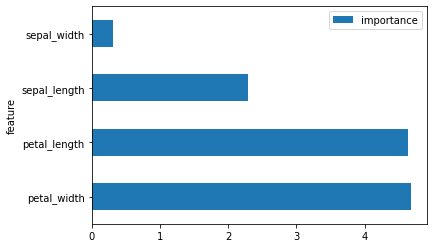

In [22]:
ax = feature_importance.plot.barh(x='feature', y='importance')
plt.show()

# Low_dim_model_coeff_features
# any linearly decoded technique
-Standardized coefficients represent the mean change in the response given a one standard deviation change in the predictor.

- plotting multinomial lr https://scikit-learn.org/dev/auto_examples/linear_model/plot_logistic_multinomial.html

In [380]:
model = model_lr

In [385]:
adata.obsm

AxisArrays with keys: X_fdg, X_tsne, X_umap

In [ ]:
latent_rep = 'PCs'

In [383]:
# Export top genes for each PC loading
coeff = pd.DataFrame(model.coef_,index = model.classes_)
df_loadings = pd.DataFrame(adata.varm['PCs'], index=adata.var_names)

KeyError: 'PCs'

In [68]:
# Export top genes for each PC loading
coeff = pd.DataFrame(model.coef_,index = lr.classes_)
df_loadings = pd.DataFrame(adata.varm['PCs'], index=adata.var_names)
df_rankings = pd.DataFrame((-1 * df_loadings.values).argsort(0).argsort(0), index=df_loadings.index, columns=df_loadings.columns)
coeff_rankings = (pd.DataFrame((-1 * coeff.T.values).argsort(0).argsort(0), index=coeff.T.index, columns=coeff.T.columns)).T

# get top loadings for each classification
# Use Cumulative distribution to determine feature importance
ranking_genes = pd.DataFrame(columns = ['class','x_pc','top_loadings','loading_val'])
for classes in coeff_rankings.index:
    print(classes)
    class_ranking = pd.DataFrame(coeff_rankings.T.loc[: , classes])
    class_ranking = class_ranking.iloc[:,0].sort_values().head(3)
    for comps in class_ranking.index:
        print(comps)
        genes = list(df_rankings[comps].sort_values().head(15).index)
        compile_classes = pd.DataFrame(columns = ranking_genes.columns)
        compile_classes.top_loadings = genes
        compile_classes.x_pc = comps
        compile_classes['class'] = classes
        compile_classes['loading_val'] = df_loadings.loc[df_loadings.index.isin(genes),comps].sort_values(ascending=False).values
        ranking_genes = pd.concat([ranking_genes,compile_classes])
        U = np.mean(df_loadings[comps])
        std = np.std(df_loadings[comps])
        med =  np.median(df_loadings[comps])
        mad = np.median(np.absolute(df_loadings[comps] - np.median(df_loadings[comps])))
        pvals = scipy.stats.norm.sf(df_loadings[comps], loc=U, scale=1*std)
        pvals = scipy.stats.norm.sf(df_loadings[comps], loc=med, scale=2*mad)
        df_loadings[str(comps) +'_pval'] = pvals

ranking_genes.to_csv('lr_features_sig.csv')
#plt.plot(coeff.iloc[0,:], coeff.iloc[0,:] + 0, '-g')
#plt.axvline(x=-0.36914894,color='blue')
#plt.axvline(x=-0.36914894,color='blue')

AEC_ys
13
1
2
CMP_ys
32
30
27
DC2_ys
41
4
10
DC_precursor_ys
11
22
21
Early_Erythroid_ys
52
79
42
Endoderm_ys
3
28
43
Eo_Baso_Mast_precursor_ys
25
19
6
Eo_Basophil_ys
25
26
19
Erythroid_ys
6
2
14
Fibroblast_ys
0
5
14
HE_ys
2
13
97
HSPC_1_ys
11
1
20
HSPC_2_ys
10
20
31
ILC_precursor_ys
23
10
11
Immature_EC_ys
2
16
24
LMPP_ys
10
36
29
Lymphoid_progenitor_ys
23
22
10
MEMP_ys
60
6
12
MK_ys
7
62
5
MOP_ys
32
6
27
Macrophage_ys
1
6
22
Mast_cell_ys
25
6
51
Mesothelium_ys
9
0
17
Microglia_ys
1
3
21
Monocyte_Macrophage_ys
16
3
33
Monocyte_ys
24
16
18
NK_ys
38
90
22
Neutrophil_precursor_ys
36
25
32
Pre_Macrophage_ys
15
23
1
Prolif_AEC_ys
13
10
7
Prolif_Sinusoidal_EC_ys
2
10
40
Promonocyte_ys
15
14
54
Sinusoidal_EC_ys
2
16
1
Smooth_Muscle_ys
0
5
14
VWF_EC_ys
20
16
2


# Plot these genes

In [70]:
pd.concat([ranking_genes.groupby(['class','x_pc']).head(3),ranking_genes.groupby(['class','x_pc']).tail(3)])

class x_pc top_loadings  loading_val
0      AEC_ys   13         GJA5     0.254285
1      AEC_ys   13         IL33     0.232750
2      AEC_ys   13      TMEM100     0.204895
0      AEC_ys    1         AIF1     0.078790
1      AEC_ys    1       LAPTM5     0.078590
..        ...  ...          ...          ...
13  VWF_EC_ys   16         AREG     0.070373
14  VWF_EC_ys   16         UPP1     0.069793
12  VWF_EC_ys    2         CD93     0.094238
13  VWF_EC_ys    2       ADGRL4     0.092574
14  VWF_EC_ys    2      MADCAM1     0.090797

[630 rows x 4 columns]

In [71]:
ranking_genes.groupby(['class','x_pc']).head(5)
ranking_genes.groupby(['class','x_pc']).tail(5)

class x_pc top_loadings  loading_val
10     AEC_ys   13        LTBP4     0.106285
11     AEC_ys   13         EMP1     0.094575
12     AEC_ys   13        EFNB2     0.092828
13     AEC_ys   13       SLC1A4     0.091128
14     AEC_ys   13         AQP1     0.087766
..        ...  ...          ...          ...
10  VWF_EC_ys    2       PECAM1     0.097085
11  VWF_EC_ys    2        APLNR     0.096024
12  VWF_EC_ys    2         CD93     0.094238
13  VWF_EC_ys    2       ADGRL4     0.092574
14  VWF_EC_ys    2      MADCAM1     0.090797

[525 rows x 4 columns]

In [72]:
rank = pd.concat([ranking_genes.groupby(['class','x_pc']).head(3),ranking_genes.groupby(['class','x_pc']).tail(3)])
plot_genes =  rank.groupby(['class'])['top_loadings'].agg(lambda grp: list(grp)).to_dict()

In [ ]:
rank = pd.concat([ranking_genes.groupby(['class','x_pc']).head(3),ranking_genes.groupby(['class','x_pc']).tail(3)])
plot_genes =  rank.groupby(['class'])['top_loadings'].agg(lambda grp: list(grp)).to_dict()
predict_grp = adata[adata.obs[common_cat].isin(group1)]
counts = (pd.DataFrame(predict_grp.obs['corr_concat'].value_counts()))
#predict_grp = predict_grp[predict_grp.obs.index.isin(predict_grp.obs.groupby('predicted').head(100).index)]
sc.pl.tracksplot(predict_grp, plot_genes, groupby='corr_concat', dendrogram=True,save = 'trackspot')

In [ ]:
rank = pd.concat([ranking_genes.groupby(['class','x_pc']).head(3),ranking_genes.groupby(['class','x_pc']).tail(3)])
plot_genes =  rank.groupby(['class'])['top_loadings'].agg(lambda grp: list(grp)).to_dict()

In [ ]:
predict_grp = adata[adata.obs[common_cat].isin(group2)]
counts = (pd.DataFrame(predict_grp.obs['predicted'].value_counts()))
#predict_grp = predict_grp[predict_grp.obs.index.isin(predict_grp.obs.groupby('predicted').head(100).index)]
sc.pl.tracksplot(predict_grp, plot_genes, groupby='corr_concat', dendrogram=True,save = 'trackspot')

In [ ]:
ranking_genes.to_csv('/nfs/team205/ig7/work_backups/backup_210306/projects/YS/YS_090321_notebooks/YS_Reprocess_250721_updates/mouse_gastrulation_human_YS_combination/lr_sig_feature_usage.csv')

# Get genes conserved between matched cellstates and differential expression within combined embedding for single classes of cells

In [ ]:
# Get conserved expression
save = 'endoderm_mouse_human_conserved.csv'
celltypes = ['ExE endoderm_4_mouse_gastrulation','Endoderm_ys']
celltype_rank = ranking_genes[ranking_genes['class'].isin(celltypes)]
celltype_rank.columns = ['cluster','xpca','gene','logfc']
celltype_rank.to_csv(save)

In [ ]:
celltype_rank

In [ ]:
adata.obs['species']

In [ ]:
# Get differential
key_add = 'de_unclust'
adata.obs[key_add] = adata.obs['corr_concat'].astype(str)
adata.obs.loc[adata.obs['species'].isin(['Mouse']),key_add]  = adata.obs.loc[adata.obs['species'].isin(['Mouse']),key_add].str.replace('_\d+_','_').astype(str)
list(adata.obs.loc[adata.obs['species'].isin(['Mouse']),key_add].unique())

In [ ]:
keep_classes = ['ExE endoderm_mouse_gastrulation','Endoderm_ys']
adata_deg = adata[adata.obs[key_add].isin(keep_classes)]

sc.tl.rank_genes_groups(adata_deg, key_add, method='wilcoxon',groups=keep_classes,n_genes=500)
sc.pl.rank_genes_groups(adata_deg, n_genes=50, sharey=False)

result = adata_deg.uns['rank_genes_groups']
groups = result['names'].dtype.names
    
DE = pd.DataFrame(
    {group + '_' + key[:1]: result[key][group]
    for group in groups for key in ['names', 'pvals','logfoldchanges']}).head(500)

DE_name ="./mouse_human_endoderm"
DE.to_csv(DE_name)

103


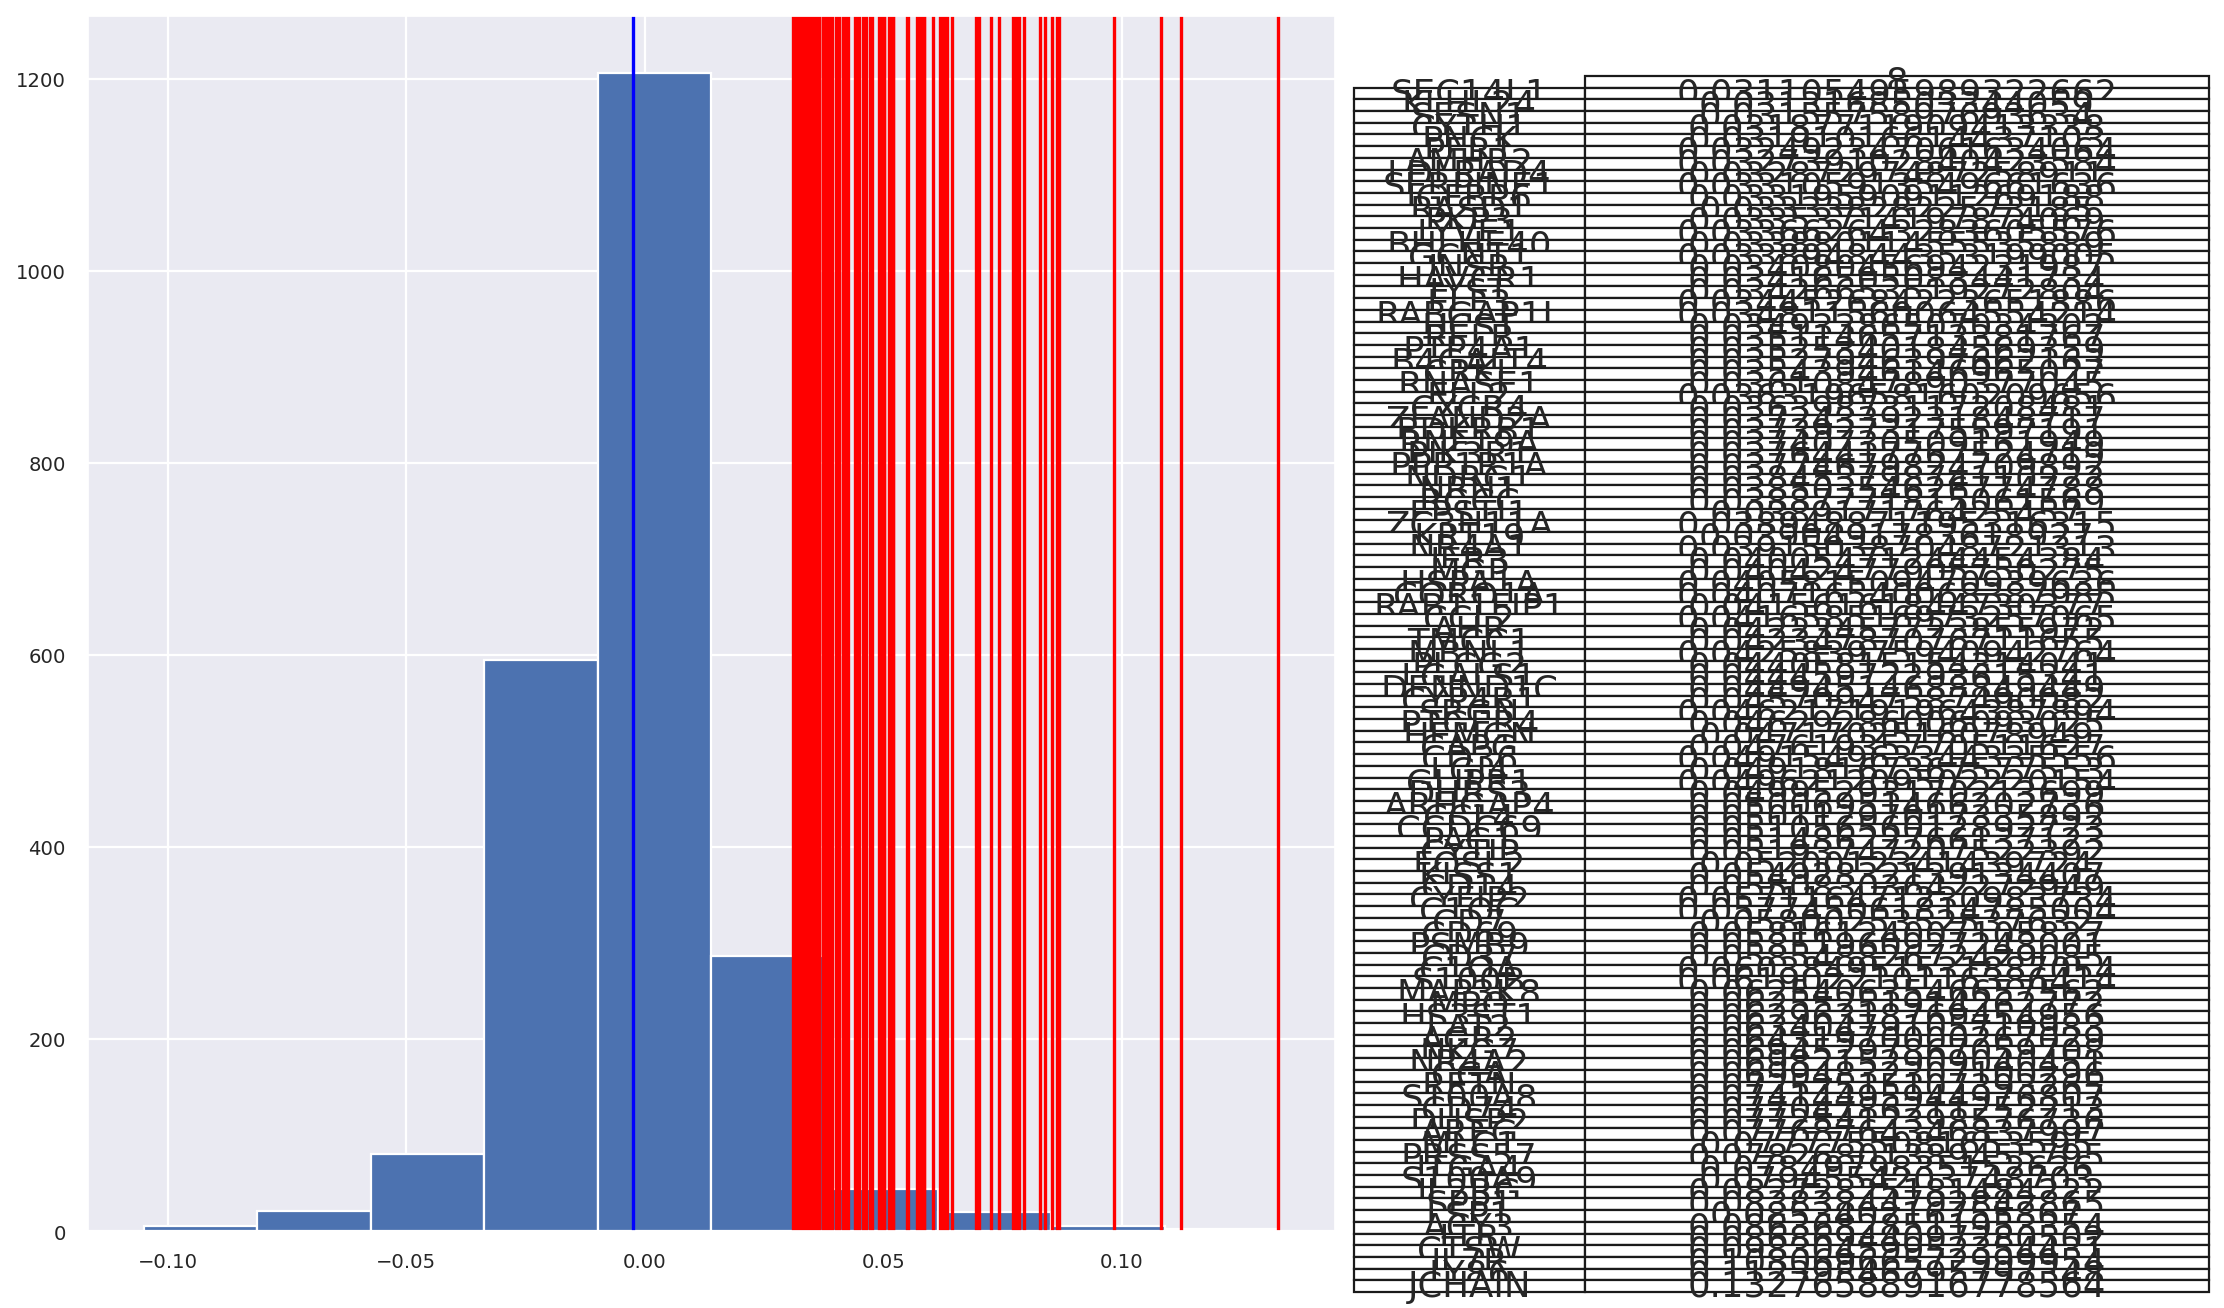

In [40]:
U = np.mean(df_loadings[comps])
std = np.std(df_loadings[comps])
med =  np.median(df_loadings[comps])
mad = np.median(np.absolute(df_loadings[comps] - np.median(df_loadings[comps])))
pvals = scipy.stats.norm.sf(df_loadings[comps], loc=med, scale=2*mad)
#pvals = scipy.stats.norm.sf(df_loadings[comps], loc=U, scale=1*std)
df_loadings[str(comps) +'_pval'] = pvals
plt.hist(df_loadings[comps])
for i in ((df_loadings[comps][df_loadings[str(comps) +'_pval']<0.05]).unique()):
    plt.axvline(x=i,color='red')
plt.axvline(x=med,color='blue')
#plt.axvline(x=med,color='pink')
df_loadings[comps][df_loadings[str(comps) +'_pval']<0.05]
print(len(df_loadings[comps][df_loadings[str(comps) +'_pval']<0.05]))
#Plot precision recall and recall
plot_loading = pd.DataFrame(pd.DataFrame(df_loadings[comps][df_loadings[str(comps) +'_pval']<0.05]).iloc[:,0].sort_values())
table = plt.table(cellText=plot_loading.values,colWidths = [1]*len(plot_loading.columns),
rowLabels=plot_loading.index,
colLabels=plot_loading.columns,
cellLoc = 'center', rowLoc = 'center',
loc='right', bbox=[1.2, -0.05, 0.5,1])
table.scale(1, 2)
table.set_fontsize(16)

In [143]:
adata =  load_adatas(adatas_dict, data_merge, adata_key)
model = load_models(models,model_key)


t0 = time.time()
class adata_temp:
    pass
from sklearn.preprocessing import StandardScaler
print('Determining model flavour')
if hasattr(model['Model'], 'coef_'):
    print('Consuming celltypist model')
    model_lr =  model['Model']
elif hasattr(model, 'coef_'):
    print('Consuming non-celltypist model')
    model_lr =  model
print(model_lr)
print('Matching reference genes in the model')
k_x = np.isin(list(adata.var.index), list(model_lr.features))
if k_x.sum() == 0:
    raise ValueError(
            f"🛑 No features overlap with the model. Please provide gene symbols")

    print(f"🧬 {k_x.sum()} features used for prediction")
#slicing adata
k_x_idx = np.where(k_x)[0]
# adata_temp = adata[:,k_x_idx]
adata_temp.var = adata[:,k_x_idx].var
# adata_temp.X = scipy.sparse.csr_matrix(adata[:,k_x_idx].X)
adata_temp.X = scipy.sparse.csr_matrix((adata[:,k_x_idx].X.shape[0], adata[:,k_x_idx].X.shape[1]), dtype=np.int8)
lr_idx = pd.DataFrame(model_lr.features, columns=['features']).reset_index().set_index('features').loc[list(adata_temp.var.index)].values
# adata_arr = adata_temp.X[:,list(lr_idexes['index'])]

# slice and reorder model
ni, fs, cf = model_lr.n_features_in_, model_lr.features, model_lr.coef_
model_lr.n_features_in_ = lr_idx.size
model_lr.features = model_lr.features[lr_idx]
model_lr.coef_ = np.squeeze(model_lr.coef_[:,lr_idx]) #model_lr.coef_[:, lr_idx]

print('scaling input data, default option is to use incremental learning and fit in mini bulks!')
# Partial scaling alg
scaler = StandardScaler(with_mean=False)
n = adata_temp.X.shape[0]  # number of rows
# set dyn scale packet size
x_len = len(adata_temp.var)
y_len = len(adata.obs)
if y_len < 100000:
    dyn_pack = int(x_len/10)
    pack_size = dyn_pack
else:
    # 10 pack for every 100,000
    dyn_pack = int((y_len/100000)*10)
    pack_size = int(x_len/dyn_pack)

batch_size =  1000#pack_size#500  # number of rows in each call to partial_fit
index = 0  # helper-var
while index < n:
    partial_size = min(batch_size, n - index)  # needed because last loop is possibly incomplete
    partial_x = adata[:,k_x_idx].X[index:index+partial_size]
    scaler.partial_fit(partial_x)
    index += partial_size
# adata_temp.X = scaler.transform(adata_temp.X)

arr_means = scaler.mean_
arr_std = scaler.scale_
n = adata_temp.X.shape[0] 
index = 0
while index < n:
    partial_size = min(batch_size, n - index)  # needed because last loop is possibly incomplete
    adata_temp.X[index:index+partial_size] = scaler.transform(adata[:,k_x_idx].X[index:index+partial_size])
#     adata_temp.X[index:index+partial_size] = (adata_temp.X[index:index+partial_size]-0)/arr_std
    index += partial_size

# # model projections
# print('Starting reference projection!')
# if train_x_partition == 'X':
#     train_x = adata_temp.X
#     pred_out = pd.DataFrame(model_lr.predict(train_x),columns = ['predicted'],index = list(adata.obs.index))
#     proba =  pd.DataFrame(model_lr.predict_proba(train_x),columns = model_lr.classes_,index = list(adata.obs.index))
#     pred_out = pred_out.join(proba)
# else: 
#     print('this partition modality has not been included in development yet!')
# ## insert modules for low dim below

# # Simple dynamic confidence calling
# pred_out['confident_calls'] = pred_out['predicted']
# pred_out.loc[pred_out.max(axis=1)<(pred_out.mean(axis=1) + (1*pred_out.std(axis=1))),'confident_calls'] = pred_out.loc[pred_out.max(axis=1)<(pred_out.mean(axis=1) + (1*pred_out.std(axis=1))),'confident_calls'].astype(str) + '_uncertain'
# # means_ = self.model.scaler.mean_[lr_idx] if self.model.scaler.with_mean else 0
print(np.max(adata_temp.X))
print(np.min(adata_temp.X))
t1 = time.time()
time_s = t1-t0
print( 'time was ' + str(time_s))

Loading anndata from web source
Loading model from web source
Determining model flavour
Consuming celltypist model
LogisticRegression(max_iter=1000, multi_class='ovr', n_jobs=-1, solver='sag')
Matching reference genes in the model
scaling input data, default option is to use incremental learning and fit in mini bulks!


/home/jovyan/my-conda-envs/workhorse/lib/python3.8/site-packages/scipy/sparse/_index.py:116: SparseEfficiencyWarning: Changing the sparsity structure of a csr_matrix is expensive. lil_matrix is more efficient.
  self._set_arrayXarray_sparse(i, j, x)


127
-128
time was 781.5120770931244


# using standard scaler

In [142]:
adata =  load_adatas(adatas_dict, data_merge, adata_key)
model = load_models(models,model_key)


t0 = time.time()
class adata_temp:
    pass
from sklearn.preprocessing import StandardScaler
print('Determining model flavour')
if hasattr(model['Model'], 'coef_'):
    print('Consuming celltypist model')
    model_lr =  model['Model']
elif hasattr(model, 'coef_'):
    print('Consuming non-celltypist model')
    model_lr =  model
print(model_lr)
print('Matching reference genes in the model')
k_x = np.isin(list(adata.var.index), list(model_lr.features))
if k_x.sum() == 0:
    raise ValueError(
            f"🛑 No features overlap with the model. Please provide gene symbols")

    print(f"🧬 {k_x.sum()} features used for prediction")
#slicing adata
k_x_idx = np.where(k_x)[0]
# adata_temp = adata[:,k_x_idx]
adata_temp.var = adata[:,k_x_idx].var
adata_temp.X = scipy.sparse.csr_matrix(adata[:,k_x_idx].X)
lr_idx = pd.DataFrame(model_lr.features, columns=['features']).reset_index().set_index('features').loc[list(adata_temp.var.index)].values
# adata_arr = adata_temp.X[:,list(lr_idexes['index'])]

# slice and reorder model
ni, fs, cf = model_lr.n_features_in_, model_lr.features, model_lr.coef_
model_lr.n_features_in_ = lr_idx.size
model_lr.features = model_lr.features[lr_idx]
model_lr.coef_ = np.squeeze(model_lr.coef_[:,lr_idx]) #model_lr.coef_[:, lr_idx]

print('scaling input data, default option is to use incremental learning and fit in mini bulks!')
# Partial scaling alg
scaler = StandardScaler(with_mean=False,copy=False)
n = adata_temp.X.shape[0]  # number of rows
# set dyn scale packet size
x_len = len(adata_temp.var)
y_len = len(adata.obs)
if y_len < 100000:
    dyn_pack = int(x_len/10)
    pack_size = dyn_pack
else:
    # 10 pack for every 100,000
    dyn_pack = int((y_len/100000)*10)
    pack_size = int(x_len/dyn_pack)

batch_size =  1000#pack_size#500  # number of rows in each call to partial_fit
index = 0  # helper-var
while index < n:
    partial_size = min(batch_size, n - index)  # needed because last loop is possibly incomplete
    partial_x = adata_temp.X[index:index+partial_size]
    scaler.partial_fit(partial_x)
    index += partial_size
adata_temp.X = scaler.transform(adata_temp.X)

# # model projections
# print('Starting reference projection!')
# if train_x_partition == 'X':
#     train_x = adata_temp.X
#     pred_out = pd.DataFrame(model_lr.predict(train_x),columns = ['predicted'],index = list(adata.obs.index))
#     proba =  pd.DataFrame(model_lr.predict_proba(train_x),columns = model_lr.classes_,index = list(adata.obs.index))
#     pred_out = pred_out.join(proba)
# else: 
#     print('this partition modality has not been included in development yet!')
# ## insert modules for low dim below

# # Simple dynamic confidence calling
# pred_out['confident_calls'] = pred_out['predicted']
# pred_out.loc[pred_out.max(axis=1)<(pred_out.mean(axis=1) + (1*pred_out.std(axis=1))),'confident_calls'] = pred_out.loc[pred_out.max(axis=1)<(pred_out.mean(axis=1) + (1*pred_out.std(axis=1))),'confident_calls'].astype(str) + '_uncertain'
# # means_ = self.model.scaler.mean_[lr_idx] if self.model.scaler.with_mean else 0
print(np.max(adata_temp.X))
print(np.min(adata_temp.X))
t1 = time.time()
time_s = t1-t0
print( 'time was ' + str(time_s))

Loading anndata from web source
Loading model from web source
Determining model flavour
Consuming celltypist model
LogisticRegression(max_iter=1000, multi_class='ovr', n_jobs=-1, solver='sag')
Matching reference genes in the model
scaling input data, default option is to use incremental learning and fit in mini bulks!
336.24994
0.0
time was 6.992662668228149


In [69]:
# scale in batches
scaler = StandardScaler(with_mean=False)
n = adata_temp.X.shape[0]  # number of rows

batch_size =  1000#pack_size#500  # number of rows in each call to partial_fit
index = 0  # helper-var
while index < n:
    partial_size = min(batch_size, n - index)  # needed because last loop is possibly incomplete
    partial_x = adata_temp.X[index:index+partial_size]
    scaler.partial_fit(partial_x)
    index += partial_size
    

In [79]:
arr_means = scaler.mean_
arr_std = scaler.scale_

n = adata_temp.X.shape[0] 
index = 0
while index < n:
    partial_size = min(batch_size, n - index)  # needed because last loop is possibly incomplete
    partial_x_arr_means = arr_means[index:index+partial_size]
    adata_temp.X[index:index+partial_size] = (adata_temp.X[index:index+partial_size]-arr_means)/arr_std
#     partial_x = adata_temp.X[index:index+partial_size]
#     scaler.partial_fit(partial_x)
    index += partial_size

In [93]:
adata_temp.X = scipy.sparse.csr_matrix(adata_temp.X)

In [94]:
adata_temp.X[index:index+partial_size] = (adata_temp.X[index:index+partial_size]-arr_means)/arr_std

In [80]:
arr_means[index:index+partial_size]

array([4.39534942e-03, 1.92441903e-02, 1.91651165e+00, 4.57558073e-02,
       9.76744201e-03, 2.38604657e-02, 2.25000065e-02, 7.52325496e-03,
       5.10465167e-03, 1.85000021e-02, 1.61662772e-01, 1.05313957e-01,
       4.88372112e-04, 5.27441911e-02, 1.31046530e-02, 3.88674408e-01,
       5.93023316e-04, 2.15116283e-03, 6.11627894e-03, 2.42805862e+00,
       2.06395343e-01, 3.35602837e+01, 7.04651093e-03, 5.63895345e-01,
       3.59302294e-03, 5.60465157e-02, 2.12337211e-01, 1.14629090e+00,
       2.33372096e-02, 7.45130301e+00, 9.35348794e-02, 1.16633730e+01,
       9.33720823e-03, 6.55813888e-03, 1.93093047e-01, 7.71860331e-02,
       1.62988380e-01, 8.15035045e-01, 1.44703472e+00, 8.34488392e-01,
       1.75813958e-02, 7.44813979e-01, 6.95965230e-01, 6.93023345e-03,
       3.30488443e-01, 1.08632529e+00, 5.92081428e-01, 1.68604648e-03,
       7.77976751e-01, 8.50465298e-02, 3.57558168e-02, 6.16279081e-04,
       1.27790701e-02, 4.05581407e-02, 1.27582550e+00, 2.06860472e-02,
      

In [77]:
arr_means = scaler.mean_
arr_std = scaler.scale_

array([4.39534942e-03, 1.92441903e-02, 1.91651165e+00, ...,
       5.53488359e-02, 3.48837275e-05, 1.92290694e-01])

In [ ]:
print('scaling input data, default option is to use incremental learning and fit in mini bulks!')
# Partial scaling alg
scaler = StandardScaler(with_mean=False)
n = adata_temp.X.shape[0]  # number of rows
# set dyn scale packet size
x_len = len(adata_temp.var)
y_len = len(adata.obs)
if y_len < 100000:
#     dyn_pack = int(x_len/10)
    pack_size = 1000
else:
    # 10 pack for every 100,000 cellsxgene
    dyn_pack = int((y_len/100000)*10)
    pack_size = int(x_len/dyn_pack)

batch_size =  1000#pack_size#500  # number of rows in each call to partial_fit
index = 0  # helper-var
while index < n:
    partial_size = min(batch_size, n - index)  # needed because last loop is possibly incomplete
    partial_x = adata_temp.X[index:index+partial_size]
    scaler.partial_fit(partial_x)
    index += partial_size
adata_temp.X = scaler.transform(adata_temp.X)


In [58]:
y_len = 205000

In [35]:
y_len/113

1000.5575221238938

In [64]:
# scale in batches of 1000 for every 10000000 points

x_len = 30000
y_len = 130000
((y_len * x_len)/ 100000)/10

3900.0

In [68]:
1000*10000

10000000

In [ ]:
# scale in batches of 1000 for every 10000000 points

In [67]:
mat_scale = y_len*x_len
mat_scale

3900000000

In [54]:
# y_len = len(adata.obs)
(y_len/10000)

20.5

In [43]:
((y_len/10000)*10)


205.0

In [21]:
pack_size

615